# Creative Extension Analysis

---


In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Hiding the warnings
import warnings; warnings.simplefilter('ignore')

# Set random seed for consistency 
import random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
seed = 42
random.seed(seed)
np.random.seed(seed)

# Importing RE (regular expression) module for preprocessing step
import re

# Natural Language Toolkits
import nltk

# used fot StopWords
import typing 
from nltk.corpus import stopwords

# Vader 
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Bert
from transformers import pipeline

#topic
from empath import Empath
import os.path

from scipy import stats
from datetime import datetime, date, time

# regression analysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Step 1. Data Collection
___

The results you are seeing are based on a follow up of a paper from [Hai Liang and King-wa Fu](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0134270). These scientists had the double aim of generalizing and testing ten propositions made in previous Twitter studies and developing an adequate and replicable sampling method to study computational social sciences. We used the same tweeter user IDs and we extracted tweets text using Twitter APIs. We took the dataset used in the mentioned paper containing the IDs for each tweet and extracted these IDs to a text file; only tweet IDs associated with english were kept. Then, we ran the tweet IDs through [Hydrator](https://github.com/DocNow/hydrator) to extract the text from each tweet. The output of the Hydrator was a JSON file containing most of the same information as in the timelines data used by the paper, but with the text of each tweet as well. After the hydrator, we kept around 66% of the tweets which amounted to 1.6 million tweets. 

## Step 2. Data Loading & Data Organization
___

In [2]:
# Loading the dataset

tweets = pd.read_csv('./Data/tweets', low_memory=False)
tweets.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,29,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False
1,NaN,Fri Sep 24 20:40:25 +0000 2010,NaN,NaN,NaN,0,25437022568,NaN,NaN,NaN,...,12,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False
2,NaN,Tue Jun 14 07:54:35 +0000 2011,NaN,NaN,http://kutiazamisli.blogspot.com/2011/06/blog-...,0,80543642816757761,NaN,NaN,NaN,...,29,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,12,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False
4,NaN,Fri Oct 25 11:38:21 +0000 2013,SmurfsVillage,NaN,http://bit.ly/Smurf47,0,393703073228808192,NaN,NaN,NaN,...,6,17,0,Land of the happily single,sheena c wallace,sheasofly,268,NaN,NaN,False


In [3]:
#reading in the dataset used in the paper of EgoAlterProfiles
ego_alt_prof = pd.read_csv('./Data/EgoAlterProfiles.txt', delimiter="\t", index_col='ID')

#visualize that the dataframe was imported correctly
ego_alt_prof.head(3)

,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
ID,,,,,,,,
1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False


In [4]:
#reading in the dataset  used in the paper of Egotimelines
ego_timelines = pd.read_csv('./Data/EgoTimelines.txt', encoding = "ISO-8859-1", delimiter = "\t")

#visualize that the dataframe was imported correctly
ego_timelines.head(3)

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
0,NaN,NaN,398477318,249552537051598848,Sat Sep 22 16:55:35 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
1,NaN,NaN,398477318,249537963145433088,Sat Sep 22 15:57:41 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
2,NaN,NaN,398477318,129377372209299456,Thu Oct 27 02:02:23 +0000 2011,NaN,NaN,NaN,0,1,NaN,NaN,NaN



## Step 3. Data Preprocessing


---

Several steps are required before starting with the analysis. Indeed, currently the dataset contains tweets in different languages and repetitive tweets created by bot accounts which need to be removed. In addition, we will preprocess the tweets themselves in order to make them more adequate for the successive analysis. The preprocessing of the tweets will be based on two main papers ([Shihab Elbagir and Jing Yang](http://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf) and 
[Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33)) which performed a sentiment analysis as we aim to do.


### Step 3.1: Tweets Cleaning Step
First, we are going to select only english tweets and delete repetitive tweets.
___

In [5]:
# Exploring the dataset

print(f"In total there are {len(tweets)} tweets.")

In total there are 1609389 tweets.


For this analysis we are only concerned with english tweets, so we need to filter the data using the language information

In [6]:
# Selecting only english tweets

en_tweets = tweets.loc[tweets['lang']=='en']
print(f"In total there are {len(en_tweets)} english tweets.")

In total there are 1093122 english tweets.


We also want to drop duplicate tweets. The reason for this is because if a tweet is repeated many times, then it is most likely due to a bot account. With this analysis we are concern with the sentiment of real users, so data from bot accounts could disrupt the results.

In [7]:
# Demonstrating examples of duplicate tweets
en_tweets['text'].value_counts()[:5]


IF U HAVE A FACEBOOK ACCOUNT,PLZ TELL ME UR ACCOUNTNAME&lt;333 U U TELL ME IT WHEN I TELL U MINE:)    2738
Here is a neat little package to create banners  http://perfecttrafficstorm.com/links/19768            171
Check this Out  http://perfecttrafficstorm.com/links/19778                                             170
Check out the PLR CHEATER http://perfecttrafficstorm.com/links/19773                                   169
Grab this package of articles    http://perfecttrafficstorm.com/links/19769                            169
Name: text, dtype: int64

In [8]:
# Dropping all duplicates tweets
en_tweets.drop_duplicates(subset=['text'], keep = False, inplace = True)
print(f"After dropping the duplicates, there are {len(en_tweets)} english tweets.")


After dropping the duplicates, there are 1054619 english tweets.


In [9]:
# Checking how many users we have 
usernames = en_tweets.value_counts(subset = 'user_name', sort = True)
print(f"There are a total of {len(usernames)} users which posted {len(en_tweets)} english tweets.")
usernames.head(5)


There are a total of 6167 users which posted 1054619 english tweets.


user_name
michelle              3906
Austin Health Jobs    3197
Mark Whittington      3189
Games For Pro         3188
BELIVE ADULT          3162
dtype: int64

In [10]:
# Giving a look to some tweet texts

for tweet in en_tweets.text.sample(n=5, random_state=0).values:
    print(tweet)


hey guys...:)
Son, It all started when your mother liked my selfie.
Rask signed for 8 years 😍😱❤
RT @HeartCapricorn: #Capricorn has one of the most sincerest hearts you will ever come across.
RT @leaderswest: How to be safe online: twenty-five things you should NEVER post by @margieclayman  http://t.co/t8Iicu6B


### Step 3.2:  Noise Removal Step
We will remove special characters from the tweets that could affect the VADER analyser but being careful to not remove any important feature which can help in understanding better the sentiment of the tweets. 

For example, we will not perform  **letter casing**, that is converting all letters in lower case. Indeed, in text such as tweets often the upper case is used to emphatise a concept: great and GREAT have a different sentiment intensity. In addition to that, as we have seen in class, casefolding could create confusion between words such as apple and Apple.  


On the contrary, we will remove unwanted characters such as URLs (“http://url”), user mentions @ ("@username"), the retweet symbols (RT @username) and hashtags symbols # (we will keep however the word of the hashtag because it might contain useful information). To do that, we follow the steps of [Shihab Elbagir and Jing Yang](http://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf) and 
[Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33).

We will also keep the "..." because they can give some insights of the tweet.
___

In [11]:
## Noise Removal 

# Using the RE (regular expression) module and the replace function to remove the unwanted characters.

# Parameters for re.sub function:
# 'r' added to not handle backslashes in any special way in the following string
# https? will match either ‘http’ or ‘https’
# https?:\/\/ will match any "http://" and "https://" in the following string
# \S Returns a match when the string does not contain a white space character inside. 
    # Indeed, we want to keep the test that follows the URL.
# * Needed to select the whole text when no white spaces in the middle

def remove_noise(text):
    # Replacing the URL with a white space
    text = re.sub(r'https?:\/\/\S*', '', text, flags = re.MULTILINE)
    
    # Replacing the www. with a white space
    text = re.sub(r'www.\S*', '', text, flags = re.MULTILINE)
    
    # Replacing the RT retweet RT @username with a white space
    text = re.sub(r'RT @\S*', '', text, flags = re.MULTILINE)
    
    # Replacing the user mention @username with a white space
    # This needs to go after the "RT @username" removal
    text = re.sub(r'@\S*', '', text, flags = re.MULTILINE)
    
    # Replacing the hashtag symbol # with a white space
    text = text.replace("#", "")
    
    # Replacing the \n (new line) with a white space
    text = text.replace("\n", "")
    
    # Returning result
    return text

# Add the new column to the original df
en_tweets['clean_tweet'] = en_tweets['text'].apply(remove_noise)

In [12]:
for i in en_tweets[en_tweets['text'] != en_tweets['clean_tweet']].sample(n=10, random_state=0).index:
    print(f"Original tweet:\t{en_tweets.loc[i].text}\nCleaned tweet:\t{en_tweets.loc[i].clean_tweet}\n")

Original tweet:	@irwienda follback y
Cleaned tweet:	 follback y

Original tweet:	RT @rihanna: Cupid stay away from my ho's!!!!
Cleaned tweet:	 Cupid stay away from my ho's!!!!

Original tweet:	RT @Cuttingbitch3: I'm the girl. http://t.co/bmcugLdGGJ
Cleaned tweet:	 I'm the girl. 

Original tweet:	listening to "Sympathy For The Devil - Rolling Stones" ♫ http://blip.fm/~5mf51
Cleaned tweet:	listening to "Sympathy For The Devil - Rolling Stones" ♫ 

Original tweet:	@MaverickSabre no bother, such a talent man, make sure you come to newcastle in the future
Cleaned tweet:	 no bother, such a talent man, make sure you come to newcastle in the future

Original tweet:	RT @joshnot_jyro: @miramontes_dee ass so fat I need a lap dance 👍😉
Cleaned tweet:	  ass so fat I need a lap dance 👍😉

Original tweet:	RT @abe_baybay: Hey guys, Water Polo beat Mission Hills too
Cleaned tweet:	 Hey guys, Water Polo beat Mission Hills too

Original tweet:	@RachelCiervo dangg, oh and btw what room are you in for capt?


### Step 3.3:  Stop words removal
___

Stop words removal is a crucial step in any natural language analysis. However, in this case, we will not use the classical english stopwords vocabulary but we will create one on our own. The goal of this part is to remove only the  stop word that the VADER's dictionary does not use ([Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33)). Deleting important words can be detrimental for the sentiment scores.

In [13]:
# Giving a look to the classical english stop words vocabulary

stopcorpus: typing.List = stopwords.words('english')
print(stopcorpus)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

As you can see, between these stop words there are some which are actually useful for our goal. For example "very" and "most" can increase the tweet sentiment intensity. Therefore, we will define a custom list of stopwords based on this one. The actual list can be found in the "helpers" folder.

In [14]:
# Selecting the stop  word from customed list of stopwords
with open("helpers/stopwords.txt") as f:
    customed_stop_words = list(map(lambda x: x[:-1], f.readlines()))

# function to remove the stop words
def remove_words(text_data: str, words_to_remove: typing.List):
    return " ".join([item for item in text_data if item not in words_to_remove])

# Applying filter for stop words and visualizing them 
en_tweets['no_sw_tweet'] = en_tweets.clean_tweet.astype(str).apply(lambda x: remove_words(x.split(), customed_stop_words))
en_tweets.head(3)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweet,no_sw_tweet
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Will try to live for a week offline... wish me...,Will try live week offline... wish luck! :D
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,Boa tarde.. ( live on,Boa tarde.. ( live
8,NaN,Sun Feb 14 18:46:26 +0000 2010,NaN,NaN,NaN,0,9107804301,NaN,NaN,NaN,...,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Phew... Valentine's day will be finally over i...,Phew... Valentine's day finally over in hours


In [15]:
# compare before and after preprocessing with a tweet that contains stopwords.
print(f"Original tweet:    \t{en_tweets.text.iloc[14]}")
print(f"Clean tweet:       \t{en_tweets.clean_tweet.iloc[14]}")
print(f"No stopwords tweet:\t{en_tweets.no_sw_tweet.iloc[14]}")

Original tweet:    	Seafood salad and fried chicken and sweet tea I'm hype. Now to cook it!!!
Clean tweet:       	Seafood salad and fried chicken and sweet tea I'm hype. Now to cook it!!!
No stopwords tweet:	Seafood salad fried chicken sweet tea I'm hype. Now cook it!!!


### Step 3.4:  Processing the data for analysis of day/hour 
___

Part of our analysis, is to understand if the moment of the day of the week can somehow influences the tweet sentiment and its retweetability. To do that, we need before to include in our dataframe the information regarding the utc_offset data and convert the time of posting in local time. This information are taken from the dataset from the original paper.

In [16]:
# Getting the egoIDs for users with UTC-offset information
ego_offsets = pd.to_timedelta(ego_alt_prof['utc_offset'], unit='seconds')

# Matching egoID offsets with tweet_ids
ego_merge = pd.merge(ego_timelines[['tweetid', 'egoID']], ego_offsets, how='inner', left_on='egoID', right_index=True)

# Matching tweet ids to get the offset for each tweet
en_tweets = pd.merge(en_tweets, ego_merge, how='inner', left_on='id', right_on='tweetid')

In [17]:
en_tweets.head(3)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweet,no_sw_tweet,tweetid,egoID,utc_offset
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Will try to live for a week offline... wish me...,Will try live week offline... wish luck! :D,9116606357,9,-1 days +21:00:00
1,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,anadadal,7,NaN,NaN,False,Boa tarde.. ( live on,Boa tarde.. ( live,499251874256920577,8,NaT
2,NaN,Sun Feb 14 18:46:26 +0000 2010,NaN,NaN,NaN,0,9107804301,NaN,NaN,NaN,...,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Phew... Valentine's day will be finally over i...,Phew... Valentine's day finally over in hours,9107804301,9,-1 days +21:00:00


In [18]:
%%time
# Normalizing time
normalize_time = lambda x: datetime.strptime(x.created_at, '%a %b %d %H:%M:%S +0000 %Y') + x.utc_offset
en_tweets['datetime'] = en_tweets.apply(normalize_time, axis=1)

CPU times: user 40.6 s, sys: 1.01 s, total: 41.6 s
Wall time: 42 s


In [19]:
# Adding hour and weekday in number and name columns
en_tweets['hour']    = en_tweets.datetime.dt.hour.astype(int, errors='ignore')
en_tweets['weekday'] = en_tweets.datetime.dt.weekday
en_tweets['weekday_name'] =  en_tweets.datetime.dt.day_name()

## Step 4. Rule-based sentiment analysis - VADER

---

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon- and rule-based sentiment analyser that can deal with words, abbreviations, slang, emoticons, and emojis commonly found in social media ([Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33)). Every text produces four sentiments scores: positive, neutral, negative and the compound polarity. The first three features describe how much the particular tweet is positive, neutral or neutral in a range between 0 and 1. On the contrary, the compound polarity score can be seen as an aggregate measure of the sentiment of the tweets, indeed it goes from - 1 (negative) and 1 (positive). In our case, we will use this polarity score to determine the sentiment of the tweets applying a threshold. From the literature, several threshoulds can be found. We decided to compared the performances of two thresholds: 0.05  )[Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33)) and 0.01 ([Shihab Elbagir and Jing Yang](http://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf)).

### Step 4.1: Results with the cleaned tweets and threshold equals to 0.05
___

In [20]:
#Initializing the Rule-based sentiment analyzer
analyzer1 = SentimentIntensityAnalyzer()

In [21]:
%%time
en_tweets['sent_score'] = en_tweets.clean_tweet.apply(lambda x: analyzer1.polarity_scores(x)['compound'])

CPU times: user 1min 13s, sys: 694 ms, total: 1min 14s
Wall time: 1min 16s


In [22]:
def sentiment_thresholding(score, th):
    if score >= th:
        sent = 'pos'
    elif score <= -th:
        sent = 'neg'
    else:
        sent = 'neu'
    return sent
    

In [23]:
en_tweets['sentiment'] = en_tweets.sent_score.apply(lambda x: sentiment_thresholding(x, th=0.05))

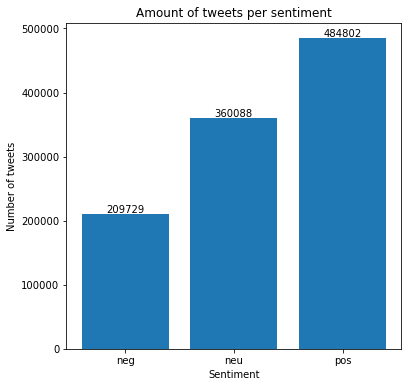

In [24]:
counts_series = en_tweets.groupby(by='sentiment').size()

plt.figure(figsize=(6,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.title('Amount of tweets per sentiment')
plt.ylabel('Number of tweets')
plt.xlabel('Sentiment')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

### Step 4.2: Results with the cleaned tweets and threshold equals to 0.001
___

In [25]:
en_tweets['sentiment_001'] = en_tweets.sent_score.apply(lambda x: sentiment_thresholding(x, th=0.01))

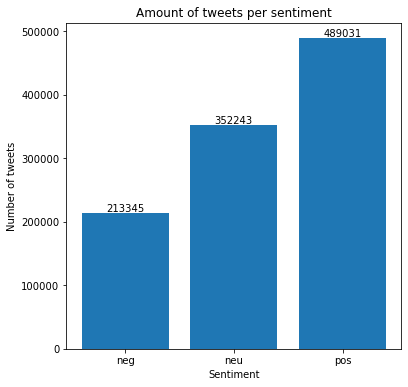

In [26]:
counts_series = en_tweets.groupby(by='sentiment_001').size()

plt.figure(figsize=(6,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.title('Amount of tweets per sentiment')
plt.ylabel('Number of tweets')
plt.xlabel('Sentiment')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

### Step 4.3 Results with the cleaned tweets without stop words

We also wanted to analyse how the stop words were affecting the VADER analyser.
___

In [27]:
# comparison of the sentiment with and without stop words

example1 = en_tweets.clean_tweet.iloc[6] 
example2 = en_tweets.no_sw_tweet.iloc[6]

analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(example1)
print(example1, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'],'\n')


vs = analyzer.polarity_scores(example2)
print(example2, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Wonders why there are so many ugly fat women on maury with sexy whores of men... How did that happen?! 

Negative sentiment: 0.278
Neutral sentiment: 0.601
Positive sentiment: 0.12
Compound sentiment: -0.6673 

Wonders so many ugly fat women maury sexy whores of men... How happen?! 

Negative sentiment: 0.37
Neutral sentiment: 0.47
Positive sentiment: 0.16
Compound sentiment: -0.6673


As we can see, removing the stop words slighly changes the negative, positive and neutral sentiment but not really the compound sentiment. This means that VADER performs already very good even with the stop words. In the next plot we can see how the total number of tweets categorized as positive, negative or neutral changes removing the stop words.

In [28]:
%%time
analyzer_no_sw = SentimentIntensityAnalyzer()
en_tweets['sent_score_no_sw'] = [analyzer_no_sw.polarity_scores(x)['compound'] for x in en_tweets['no_sw_tweet']]
en_tweets['sentiment_no_sw'] = en_tweets.sent_score_no_sw.apply(lambda x: sentiment_thresholding(x, th=0.05))

CPU times: user 1min 1s, sys: 740 ms, total: 1min 1s
Wall time: 1min 4s


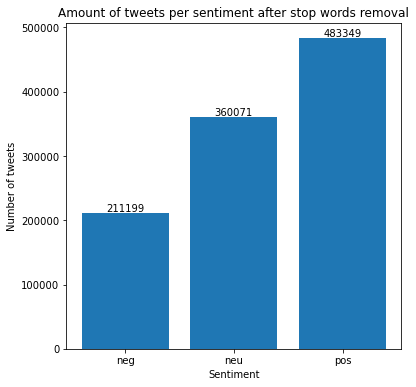

In [29]:
counts_series = en_tweets.groupby(by='sentiment_no_sw').size()

plt.figure(figsize=(6,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.title('Amount of tweets per sentiment after stop words removal')
plt.ylabel('Number of tweets')
plt.xlabel('Sentiment')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

As we can see, slightly changing the threshold or including the stops words does not strongly affect the distribution of sentiments.

## Step 5. Sentiment Analysis with BERT-based model

### Explain a little bit what BERT is and also what you did for pre traine the model.
### Comment also code in step 6
___

In [30]:
bert_labeled_tweets_path = Path('Data/bert_sa_labeled_tweets.csv')

if not bert_labeled_tweets_path.exists():
    bert_labeled_tweets = en_tweets.reset_index()
    sa_pipeline = pipeline('sentiment-analysis')

    batch_size = 128
    texts = list(bert_labeled_tweets['clean_tweet'])
    predictions = []
    for i in tqdm(range(0, len(texts), batch_size)):
        predictions += sa_pipeline(texts[i:i + batch_size])
        
    assert len(predictions) == len(texts)
    assert len(texts) == len(en_tweets)
    
    predictions = pd.DataFrame(predictions)
    bert_labeled_tweets['bert_sentiment'] = predictions['label'].apply(lambda l: label_renaming[l])
    bert_labeled_tweets['bert_score'] = predictions['score']
    
    bert_labeled_tweets = bert_labeled_tweets[['id', 'bert_sentiment', 'bert_score']]
    bert_labeled_tweets.to_csv('Data/bert_sa_labeled_tweets.csv', index=False)
else:
    bert_labeled_tweets = pd.read_csv('./Data/bert_sa_labeled_tweets.csv')

In [31]:
bert_labeled_tweets.head()

,id,bert_sentiment,bert_score
0,9116606357,pos,0.866500
1,499251874256920577,neg,0.624708
2,9107804301,neg,0.985702
3,251759950655791105,pos,0.997911
4,251759653464199168,neg,0.958070


In [32]:
subjectivity_mask = (en_tweets['sentiment'] == 'pos') | (en_tweets['sentiment'] == 'neg')
subjective_tweets = en_tweets[subjectivity_mask]

subjective_tweets = pd.merge(subjective_tweets, bert_labeled_tweets, how='inner')
assert sum(subjectivity_mask) == len(subjective_tweets)

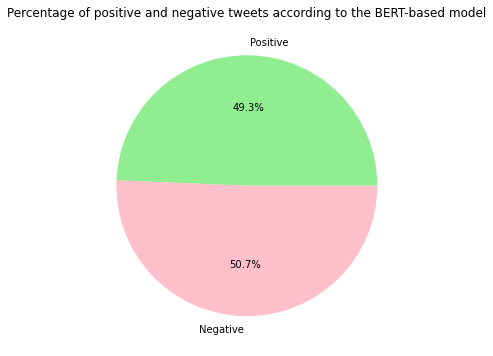

In [33]:
plt.figure(figsize=(6,6))

bert_pos_count = sum(subjective_tweets['bert_sentiment'] == 'pos')
bert_neg_count = sum(subjective_tweets['bert_sentiment'] == 'neg')

data = [bert_pos_count, bert_neg_count]
colors = ['lightgreen', 'pink']
labels=['Positive', 'Negative']

plt.pie(data, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Percentage of positive and negative tweets according to the BERT-based model')
plt.show()

# Step 6. Agreement between the classifiers

We want to find the agreement between both the VADER sentiment analysis and the pre-trained BERT model. We find this agreement to insure robust results and allow us to be more confident that the tweets identified as positive are actually positive and the ones identified as negative are actually negative. Where ever there was a disagreement, the sentiment was changed to be neutral. Since we are simply comparing positive and negative tweets in our analysis, it is okay to have an increase in neutral tweets. In this case, it is better to be more confident that the tweets in each category actually belong in that category. 

In [34]:
vader_pos_mask = subjective_tweets['sentiment'] == 'pos'
vader_neg_mask = subjective_tweets['sentiment'] == 'neg'
bert_pos_mask = subjective_tweets['bert_sentiment'] == 'pos'
bert_neg_mask = subjective_tweets['bert_sentiment'] == 'neg'
pos_pos = sum(vader_pos_mask & bert_pos_mask)
pos_neg = sum(vader_pos_mask & bert_neg_mask)
neg_pos = sum(vader_neg_mask & bert_pos_mask)
neg_neg = sum(vader_neg_mask & bert_neg_mask)

total = len(subjective_tweets)

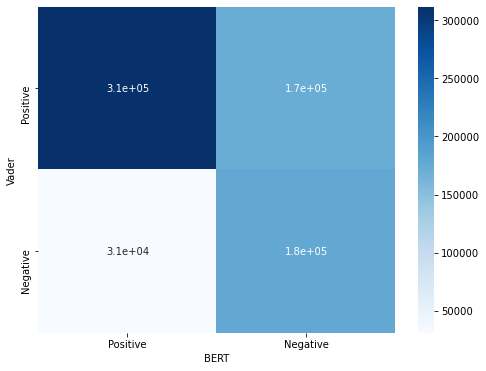

In [35]:
agreement_df = pd.DataFrame([[pos_pos, pos_neg], [neg_pos, neg_neg]], index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, annot=True, cmap='Blues')
plt.xlabel('BERT')
plt.ylabel('Vader')
plt.show()

In [36]:
disagreement_mask = (vader_pos_mask & bert_neg_mask) | (vader_neg_mask & bert_pos_mask)
subjective_tweets[disagreement_mask][['text', 'sentiment', 'bert_sentiment']].head()

,text,sentiment,bert_sentiment
7,Smurfy Tip: Use stardust to clear new areas on...,pos,neg
8,Why am I up its too early and my son wants to ...,pos,neg
11,Defense wins championships. #letsgodetroit @Lions,pos,neg
15,Nobody likes you when you're 23. #blink182 #th...,pos,neg
19,the struggle is real....#YeezusTour #bills #pa...,neg,pos


In [37]:
observed_proportionate_agreement = (pos_pos + neg_neg) / total
print(f'The observed proportionate agreement betweent the classifiers is: {observed_proportionate_agreement:.2f}')

The observed proportionate agreement betweent the classifiers is: 0.71


In [38]:
p_pos = (pos_pos + pos_neg) * (pos_pos + neg_pos) / (total ** 2)
p_neg = (neg_neg + neg_pos) * (neg_neg + pos_neg) / (total ** 2)
random_agreement_probability = p_pos + p_neg
random_agreement_probability
print(f'The probability of random agreement between the classifiers is: {random_agreement_probability:.2f}')

The probability of random agreement between the classifiers is: 0.50


In [39]:
cohen_kappa = (observed_proportionate_agreement - random_agreement_probability) / (1 - random_agreement_probability)
print(f"The Cohen's kappa coefficient is: {cohen_kappa:.2f}")

The Cohen's kappa coefficient is: 0.42


In this analysis, we consider a tweet as either positive or negative when both the rule-based estimator and the pre-trained BERT models agree on the label

In [40]:
en_tweets = pd.merge(en_tweets, bert_labeled_tweets, on='id')

In [41]:
en_tweets['vader_sentiment'] = en_tweets['sentiment']
agreement_mask = en_tweets['vader_sentiment'] == en_tweets['bert_sentiment']
en_tweets['sentiment'] = 'neu'
en_tweets['sentiment'][agreement_mask] = en_tweets['vader_sentiment']
en_tweets.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,weekday,weekday_name,sent_score,sentiment,sentiment_001,sent_score_no_sw,sentiment_no_sw,bert_sentiment,bert_score,vader_sentiment
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,6.0,Sunday,0.8599,pos,pos,0.8599,pos,pos,0.866500,pos
1,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,NaN,NaN,0.0000,neu,neu,0.0000,neu,neg,0.624708,neu
2,NaN,Sun Feb 14 18:46:26 +0000 2010,NaN,NaN,NaN,0,9107804301,NaN,NaN,NaN,...,6.0,Sunday,0.0000,neu,neu,0.0000,neu,neg,0.985702,neu
3,NaN,Fri Sep 28 19:07:04 +0000 2012,NaN,NaN,http://twitcam.livestream.com/c7fe0,0,251759950655791105,NaN,NaN,NaN,...,NaN,NaN,0.0000,neu,neu,0.0000,neu,pos,0.997911,neu
4,NaN,Fri Sep 28 19:05:53 +0000 2012,NaN,NaN,http://twitcam.livestream.com/c7fe0,0,251759653464199168,NaN,NaN,NaN,...,NaN,NaN,0.0000,neu,neu,0.0000,neu,neg,0.958070,neu


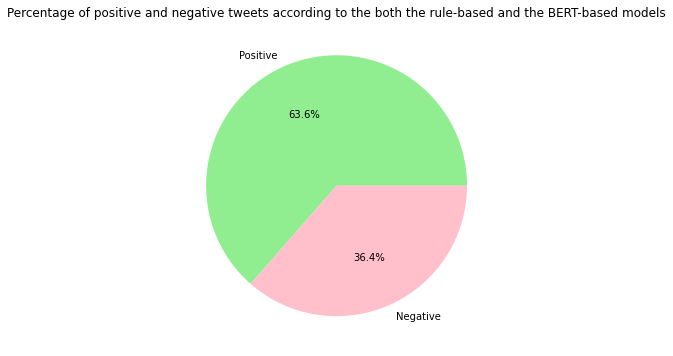

Total number of subjective (positive or negative) tweets: 490629


In [42]:
plt.figure(figsize=(6,6))

pos_count = sum(en_tweets['sentiment'] == 'pos')
neg_count = sum(en_tweets['sentiment'] == 'neg')
# neu_count = sum(en_tweets['sentiment'] == 'neu')

data = [pos_count, neg_count]
colors = ['lightgreen', 'pink']
labels=['Positive', 'Negative']

plt.pie(data, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Percentage of positive and negative tweets according to the both the rule-based and the BERT-based models')
plt.show()
print(f'Total number of subjective (positive or negative) tweets: {pos_count + neg_count}')

## Step 7: Sentiment VS time
___

For the following analysis we will focus only on subjective (positive and negative tweets). The aim is to understand is the day of the week of the hour of the day has an effect on the sentiments of the tweets. For example, it would have been interesting to notice an increase in the negative tweets on monday morning. However, as we will see, positive and negative sentiments share a similar trend throughout the week and the day.

In [43]:
# removing tweets without utc_offset information
en_tweets_time = en_tweets.dropna(subset=['utc_offset'])

# keeping only positive and negative tweets
pos_sents_time = en_tweets_time.loc[en_tweets_time['sentiment'] == 'pos']
neg_sents_time = en_tweets_time.loc[en_tweets_time['sentiment'] == 'neg']

In [44]:
# weekday names
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [45]:
# Calculating the total number of retweets per hour in total and divided by sentiment
tweet_per_h = en_tweets_time.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])
pos_tweet_per_h = pos_sents_time.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])
neg_tweet_per_h = neg_sents_time.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])

In [46]:
tweet_per_h

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Mon,4401,2824,1891,1535,1252,1252,1688,2537,3615,3744,...,5063,4983,5231,5180,5617,6300,6627,6972,6663,5420
Tue,4041,2798,1926,1351,1214,1257,2030,2783,3508,4150,...,4981,5170,5261,4984,5318,5971,6352,6467,6646,5704
Wed,4114,2840,2040,1582,1347,1336,1843,2625,3637,4204,...,5126,5416,5107,5021,5286,5607,6126,6350,6598,5582
Thu,4082,2950,1989,1640,1299,1228,1854,2581,3640,4140,...,5209,4900,5284,5081,5755,5932,5980,6638,6215,5670
Fri,4040,2669,2373,1597,1268,1419,2057,2926,3597,4236,...,4925,5002,5057,4697,4691,4946,5017,5419,5504,4778
Sat,3808,2880,2151,1701,1323,1385,1451,2107,2704,3406,...,4341,4307,4473,4450,4964,5230,5265,5618,5291,5178
Sun,4469,3227,2375,1711,1356,1182,1270,1689,2108,2921,...,4660,4628,4917,4536,4928,5948,6378,6981,6915,5985


In [47]:
# Defining colors for the plots
colors = ['tomato', 'darkgoldenrod', 'limegreen', 'lightseagreen', 'deepskyblue', 'slateblue','magenta']

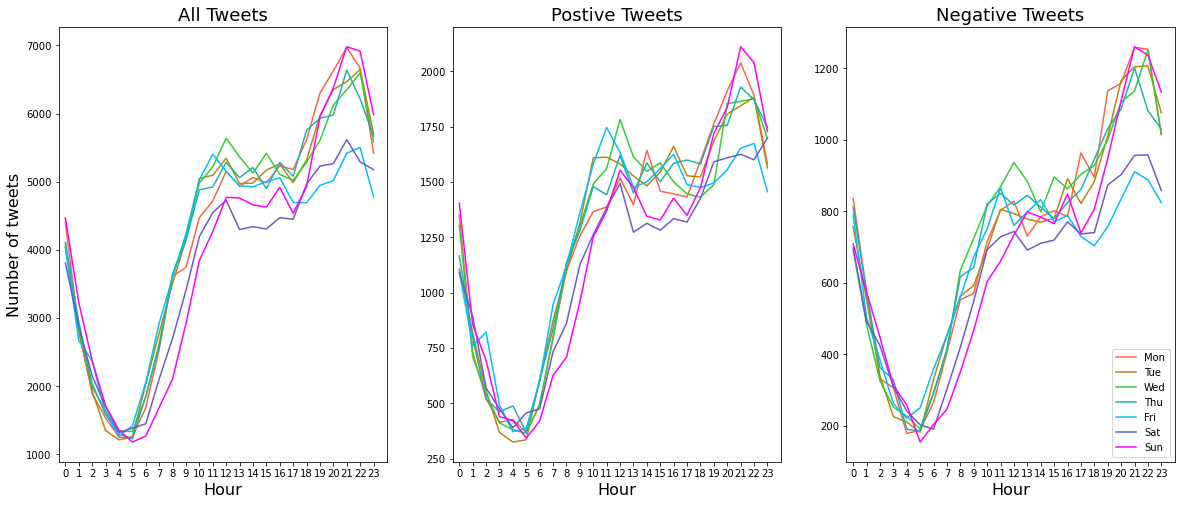

In [48]:
plt.figure(figsize=(20,8))

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize= 16)
plt.ylabel('Number of tweets', fontsize= 16)
plt.title('All Tweets',fontsize= 18)


for i in range(7):
    plt.plot(tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize= 16)
plt.title('Postive Tweets', fontsize= 18)


for i in range(7):
    plt.plot(pos_tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize= 16)
plt.title('Negative Tweets', fontsize= 18)


for i in range(7):
    plt.plot(neg_tweet_per_h.iloc[i],c=colors[i])
    plt.legend(weekday_names, loc='lower right')

plt.show()

We see that the positive and negative sentiment tweets have the same trend as all the tweets, so we can conclude that the day of the week or hour of the day does not have an affect on the sentiment. We see that the number of tweets general increases throughout the day for all days of the week. It appears that the total number of tweets is higher on the weekdays and lower on the weekends

## Step 8: Retweetability VS time
___

We were also interested in understanding if the time of the day and the day of the weeks would somehow affect the retweetability. Retweetability is defined as if the tweet is retweeted or not, regardless of the retweet count.

#### Step 8.1: Percentage values of retweets

Here we will compare the percentare of retweeted twees for three categories: total, positive and negative tweets. The percentage is calculated as the number of retweeted tweets over the total number of tweets in that category.

In [49]:
# creating df with only non retweeted tweets
# it will be used to calculate the percentage of retweeted tweets
retweet_0_count = en_tweets_time.loc[en_tweets_time['retweet_count'] == 0]
pos_retweet_0_count =  pos_sents_time.loc[pos_sents_time['retweet_count'] == 0]
neg_retweet_0_count =  neg_sents_time.loc[neg_sents_time['retweet_count'] == 0]

# creating df with only retweeted tweets
retweeted_count = en_tweets_time.loc[en_tweets_time['retweet_count'] > 0]
pos_retweeted_count = pos_sents_time.loc[pos_sents_time['retweet_count'] > 0]
neg_retweeted_count = neg_sents_time.loc[neg_sents_time['retweet_count'] > 0]


In [50]:
#grouping the not retweeted count by day and hour and getting the size of each group
retweet_0_count_per_h = retweet_0_count.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])
pos_retweet_0_count_per_h = pos_retweet_0_count.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])
neg_retweet_0_count_per_h = neg_retweet_0_count.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])

#grouping the retweeted count by day and hour and getting the size of each group
retweeted_count_per_h = retweeted_count.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])
pos_retweeted_count_per_h = pos_retweeted_count.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])
neg_retweeted_count_per_h = neg_retweeted_count.groupby(['weekday','hour']).size().unstack().set_index([weekday_names])


In [51]:
retweet_0_count_per_h

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Mon,3188,2199,1573,1262,1031,961,1321,1968,2834,2949,...,3983,3851,4081,3968,4397,4844,5043,5382,5053,4053
Tue,3155,2250,1523,1129,985,1028,1567,2215,2686,3100,...,3797,4000,4085,3871,4129,4557,4787,4967,5092,4418
Wed,3158,2255,1659,1308,1069,1034,1403,2033,2827,3247,...,3928,4188,3909,3891,4136,4411,4751,4964,5075,4194
Thu,2996,2287,1590,1296,1035,944,1418,2065,2803,3038,...,3932,3813,4041,3979,4526,4673,4718,5213,4784,4527
Fri,3098,2200,1865,1279,993,1133,1595,2261,2807,3261,...,3829,3918,3935,3675,3727,3875,3946,4274,4216,3655
Sat,2990,2326,1761,1446,1017,1149,1159,1698,2157,2609,...,3362,3360,3504,3491,3989,4168,4179,4380,4145,4009
Sun,3467,2505,1852,1385,1095,982,1023,1348,1648,2279,...,3562,3550,3871,3423,3861,4538,4916,5301,5233,4570


In [52]:
#function to calculate the percentage retweeted of two dfs
def perc_rt(df1, df2):
    tot = df1 + df2
    perc = (df1/tot)*100
    return perc

In [53]:
#creating dfs with percentage of tweets retweeted per hour

perc_rt_per_h = perc_rt(retweeted_count_per_h, retweet_0_count_per_h)
pos_perc_rt_per_h = perc_rt(pos_retweeted_count_per_h, pos_retweet_0_count_per_h)
neg_perc_rt_per_h = perc_rt(neg_retweeted_count_per_h, neg_retweet_0_count_per_h)

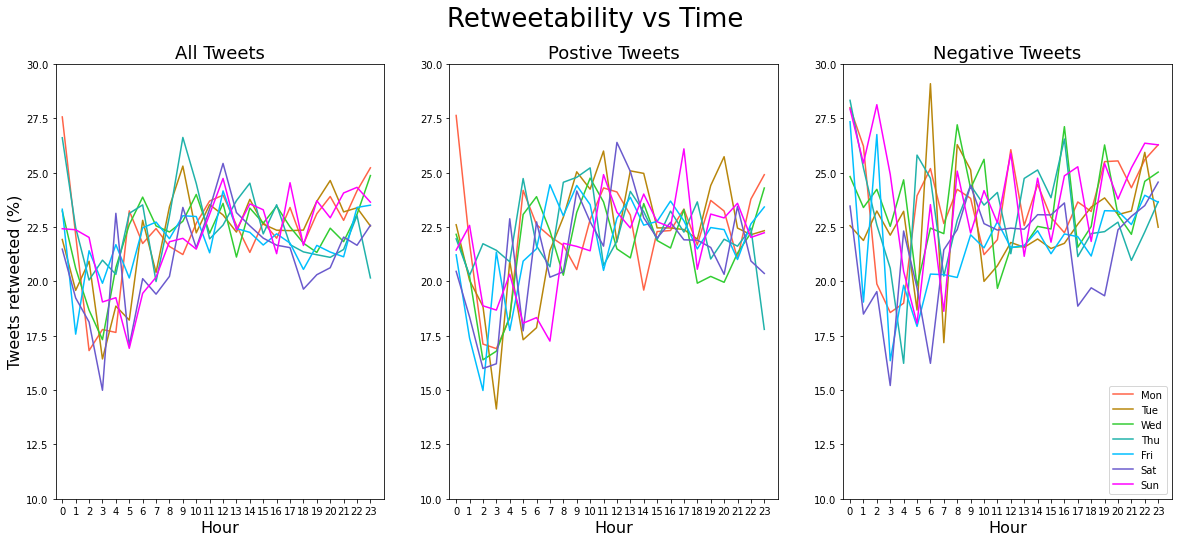

In [54]:
# plotting the percentage of retweeted tweets in the three categories: total, positive and negative tweets

plt.figure(figsize=(20,8))
plt.suptitle('Retweetability vs Time',fontsize=26)

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.ylim(10, 30)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Tweets retweeted (%)',fontsize=16)
plt.title('All Tweets', fontsize=18)


for i in range(7):
    plt.plot(perc_rt_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.ylim(10, 30)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize=16)
plt.title('Postive Tweets',fontsize=18)


for i in range(7):
    plt.plot(pos_perc_rt_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.ylim(10, 30)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize=16)
plt.title('Negative Tweets',fontsize=18)


for i in range(7):
    plt.plot(neg_perc_rt_per_h.iloc[i],c=colors[i])
    plt.legend(weekday_names, loc='lower right')

plt.show()

As it is, this plot is a bit messy and not easy to understand. Let's aggregate the days of the week in weekdays and weekends to make it more readable.

In [55]:
# defining function to get weekdays and weekends
def wd_we(df):
    wd = df.iloc[0:4].sum()
    we = df.iloc[4:7].sum()
    df = pd.DataFrame(data = {'weekday': wd, 'weekend': we}).transpose()
    return df

In [56]:
# applying the function to aggregate by weekend and weekdays the retweet count per hour for total, positive 
# and negative tweets for both retweeted and non retweeted tweets. 

ret_tot_0 = wd_we(retweet_0_count_per_h)
ret_pos_0 = wd_we(pos_retweet_0_count_per_h)
ret_neg_0 = wd_we(neg_retweet_0_count_per_h)

ret_tot = wd_we(retweeted_count_per_h)
ret_pos = wd_we(pos_retweeted_count_per_h)
ret_neg = wd_we(neg_retweeted_count_per_h)

# get the percentages 
perc_tot = perc_rt(ret_tot , ret_tot_0)
perc_pos = perc_rt(ret_pos , ret_pos_0)
perc_neg = perc_rt(ret_neg , ret_neg_0)

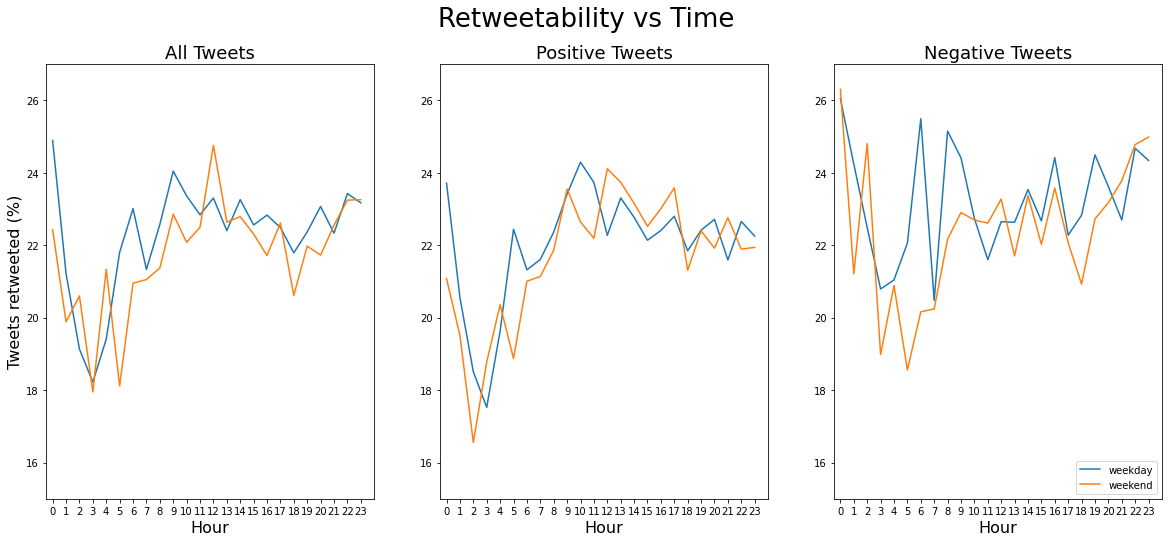

In [57]:
# plot 

plt.figure(figsize=(20,8))
plt.suptitle('Retweetability vs Time',fontsize=26)

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.ylim(15, 27)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Tweets retweeted (%)',fontsize=16)
plt.title('All Tweets', fontsize=18)


for i in range(2):
    plt.plot(perc_tot.iloc[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.ylim(15, 27)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize=16)
plt.title('Positive Tweets',fontsize=18)


for i in range(2):
    plt.plot(perc_pos.iloc[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.ylim(15, 27)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour',fontsize=16)
plt.title('Negative Tweets',fontsize=18)


for i in range(2):
    plt.plot(perc_neg.iloc[i])
    plt.legend(['weekday','weekend'], loc='lower right')



plt.show()

The plot now looks cleaner. We can see that the percentage of positive and negative retweets is similar, around 20-22%. However, negative tweets seems to be retweeted more often and their retweetability is higher during the night-early morning (0-6am), in particular during the weekdays.

On average, during the weekdays there is an higher percentage of retweets both in negative and in positive tweets with the exception of positive tweets posted between 11am - 4pm , when the retweetability of tweets posted during the weekendis higher. 


#### Step 8.2: Total number of retweets

Here we want to compare the total sum of retweeted tweets for the three categories. 

In [58]:
# Calculating the total number of retweets per hour in total and divided by sentiment
retweet_per_h = en_tweets_time.groupby(['weekday','hour'])['retweet_count'].agg('sum').unstack()
pos_retweet_per_h = pos_sents_time.groupby(['weekday','hour'])['retweet_count'].agg('sum').unstack()
neg_retweet_per_h = neg_sents_time.groupby(['weekday','hour'])['retweet_count'].agg('sum').unstack()

# ordering by the new index
retweet_per_h = retweet_per_h.set_index([weekday_names])
pos_retweet_per_h = pos_retweet_per_h.set_index([weekday_names])
neg_retweet_per_h = neg_retweet_per_h.set_index([weekday_names])

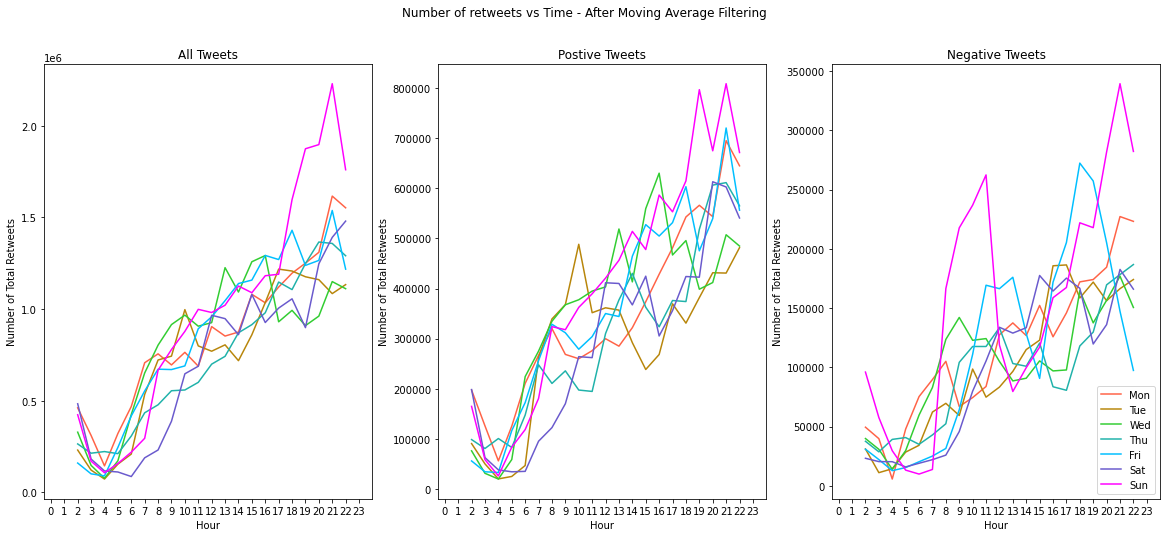

In [59]:
# Applying a rolling mean to smooth the plots
average_h = 4
retweet_per_h_mean = np.transpose(retweet_per_h).rolling(average_h, center=True).mean().dropna()
pos_retweet_per_h_mean = np.transpose(pos_retweet_per_h).rolling(average_h, center=True).mean().dropna()
neg_retweet_per_h_mean  = np.transpose(neg_retweet_per_h).rolling(average_h, center=True).mean().dropna()


# go back to original shape
retweet_per_h_mean = np.transpose(retweet_per_h_mean)
pos_retweet_per_h_mean = np.transpose(pos_retweet_per_h_mean)
neg_retweet_per_h_mean = np.transpose(neg_retweet_per_h_mean)

# showing the plot  with moving average

plt.figure(figsize=(20,8))
plt.suptitle('Number of retweets vs Time - After Moving Average Filtering')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of Total Retweets')
plt.title('All Tweets')


for i in range(7):
    plt.plot(retweet_per_h_mean.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of Total Retweets')
plt.title('Postive Tweets')


for i in range(7):
    plt.plot(pos_retweet_per_h_mean.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of Total Retweets')
plt.title('Negative Tweets')


for i in range(7):
    plt.plot(neg_retweet_per_h_mean.iloc[i],c=colors[i])
    plt.legend(weekday_names, loc='lower right')

plt.show()

From the plots above, we can see that the retweets, similar to the tweets, follow the circadiam rhythm as shown in the original paper. The only exception can be seen for sunday morning where there is a boost in retweets and friday nigth were the number of retweets drop.

#### Step 8.3:  Average retweet count per tweets

Here we want to compare the average retweet count per tweets over the day and the week. For average retweet count we mean the fraction of retweets for the total number of tweets published in the three categories mentioned above.

In [60]:
# calculating the average of retweets per hour over the total number of tweets posted in the same time slot
aver_tot = retweet_per_h/tweet_per_h
aver_pos = pos_retweet_per_h/pos_tweet_per_h
aver_neg = neg_retweet_per_h/neg_tweet_per_h


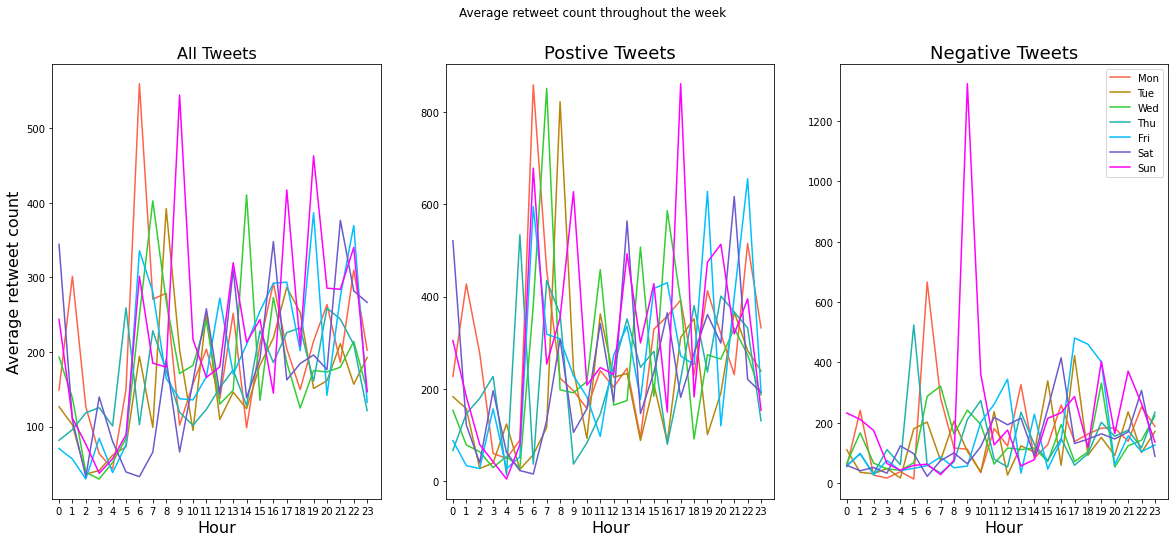

In [61]:
# plotting average number of retweets 

plt.figure(figsize=(20,8))
plt.suptitle('Average retweet count throughout the week')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Average retweet count', fontsize=16)
plt.title('All Tweets', fontsize=16)


for i in range(7):
    plt.plot(aver_tot.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.title('Postive Tweets', fontsize=18)


for i in range(7):
    plt.plot(aver_pos.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.title('Negative Tweets', fontsize=18)


for i in range(7):
    plt.plot(aver_neg.iloc[i],c=colors[i])
    plt.legend(weekday_names, loc='upper right')

plt.show()

As seen in step 8.1, the plots above are a bit messy. To make it clearer we opted for two different solution. The first one we already seen, we can aggregate data per weekdays and weekends. In addition, we can apply a threshold and focus on a particular section of the picture. However, in the last case, the presence of outliers have a bigger effect because data are not averaged as it happens aggregating them per weekdays and weekends.

#### Aggregating by weekdays and weekends

In [62]:
# Defining a function to return the average
def wd_we_averg(df1, df2):
    wd1 = df1.iloc[0:4].sum()
    we1 = df1.iloc[4:7].sum()
    wd2 = df2.iloc[0:4].sum()
    we2 = df2.iloc[4:7].sum()
    
    df1 = pd.DataFrame(data = {'weekday': wd1, 'weekend': we1}).transpose()
    df2 = pd.DataFrame(data = {'weekday': wd2, 'weekend': we2}).transpose()

    return df1/df2

# defining the retweets/tweets for the three categories
week_avg_tot = wd_we_averg(retweet_per_h,tweet_per_h)
week_avg_pos = wd_we_averg(pos_retweet_per_h,pos_tweet_per_h)
week_avg_neg = wd_we_averg(neg_retweet_per_h,neg_tweet_per_h)


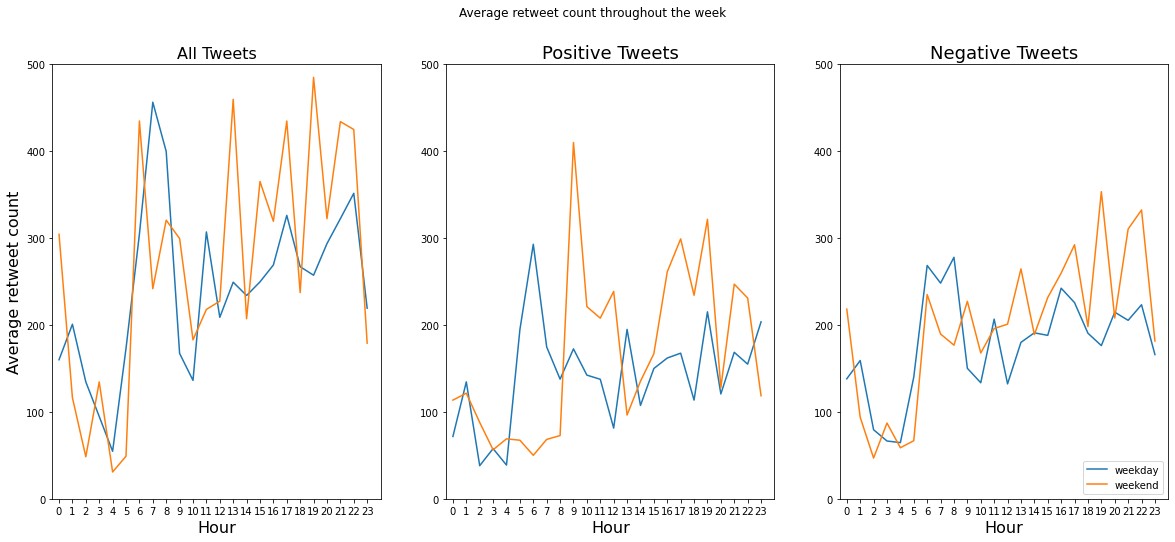

In [63]:
# new plot grouping by weekdays and weekends

plt.figure(figsize=(20,8))
plt.suptitle('Average retweet count throughout the week')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.ylim(0, 500)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Average retweet count', fontsize=16)
plt.title('All Tweets', fontsize=16)


for i in range(2):
    plt.plot(week_avg_pos.iloc[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.ylim(0, 500)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.title('Positive Tweets', fontsize=18)


for i in range(2):
    plt.plot(week_avg_neg.iloc[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.ylim(0, 500)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.title('Negative Tweets', fontsize=18)


for i in range(2):
    plt.plot(week_avg_tot.iloc[i])
    plt.legend(['weekday','weekend'], loc='lower right')

plt.show()

Grouping by day of the week or the weekend we can see that positive tweets posted during the day are more retweeted during the weekend with the exception of tweets posted from 4am to 8 am, that get retweeted more during the weekday, probably because people are already awake during the week. 
For negative tweets the difference between weekday and weekend is not so big, but it follow the same trend of the positive ones.

#### Zooming in the original plot

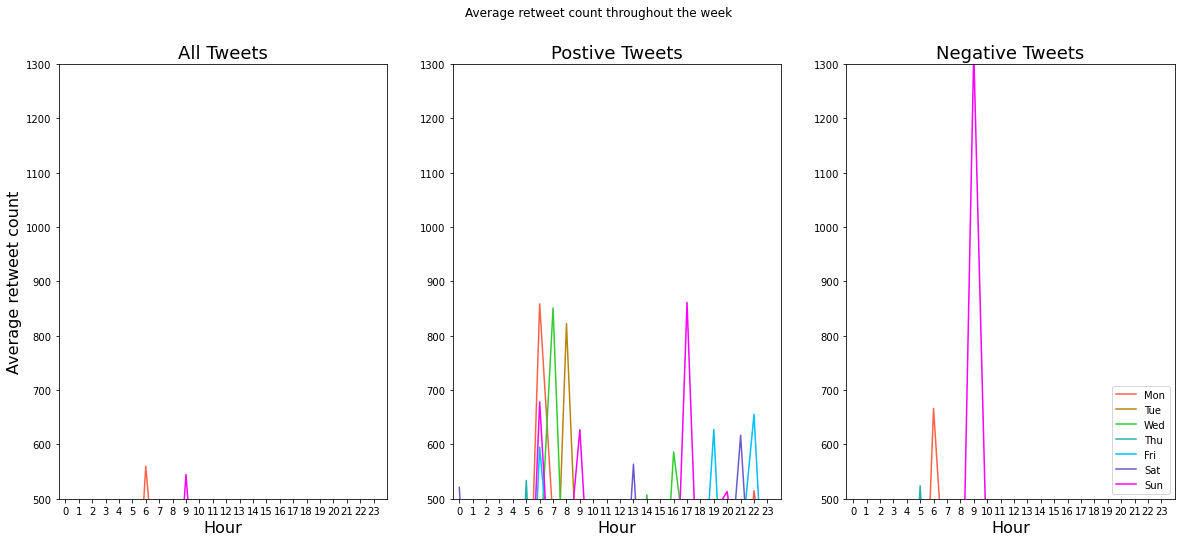

In [64]:
# same plot of before but doing a focus in the plots

plt.figure(figsize=(20,8))
plt.suptitle('Average retweet count throughout the week')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.ylim(500,1300)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Average retweet count', fontsize=16)
plt.title('All Tweets', fontsize=18)


for i in range(7):
    plt.plot(retweet_per_h.iloc[i]/tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.ylim(500,1300)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.title('Postive Tweets', fontsize=18)


for i in range(7):
    plt.plot(pos_retweet_per_h.iloc[i]/pos_tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.ylim(500,1300)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour', fontsize=16)
plt.title('Negative Tweets', fontsize=18)


for i in range(7):
    plt.plot(neg_retweet_per_h.iloc[i]/neg_tweet_per_h.iloc[i],c=colors[i])
    plt.legend(weekday_names, loc='lower right')
plt.savefig('moment.png', bbox_inches='tight')
plt.show()

Focusing only in the upper part of the plots enable us to see only the days and the hours where the retweets count is higher. For example, we can clearly see that negative tweets published on Sunday around 9 am have the highest number of average retweets per tweets, followed by Sunday at 5 pm and Monday at 6 am for positive tweets. As we already saif though, this values can suffer by the effect of some very popular tweets in these time slots.

# Step 9. Tweet sentiment VS Retweetability

___

In [65]:
# creating two df for positive and negative tweets for which bert and vader are in agreement
pos_sents = en_tweets.loc[en_tweets['sentiment'] == 'pos']
neg_sents = en_tweets.loc[en_tweets['sentiment'] == 'neg']

Naive analysis on affect of sentiment on retweet count 

In [66]:
#The ktest can also be used to see if two datasets come from the same distribution

stats.ks_2samp(pos_sents.retweet_count, neg_sents.retweet_count, alternative='greater')

KstestResult(statistic=0.01665655576030345, pvalue=4.05066690752909e-28)

Before removing the tweets with no retweets the positive tweets appeared to come from a distribution that is greater than negative tweets distribution because we reject the Null hypothesis from the Ks test. The null hypothesis is that the two distributions are equal and we reject this in favour of the alternative which is that the distribution from the positive tweets is greater.

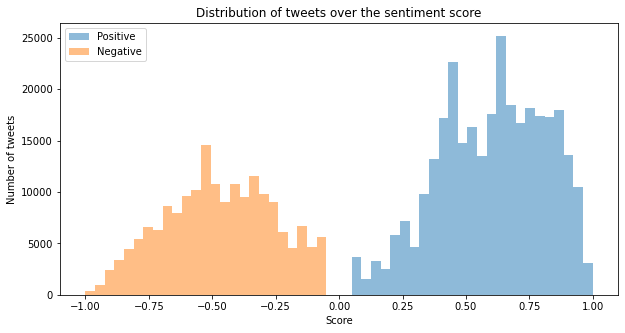

In [67]:
# Distribution of tweets over the sentiment score from VADER

plt.figure(figsize=(10,5))
plt.hist(pos_sents.sent_score, bins=25, alpha=0.5, label="Positive")
plt.hist(neg_sents.sent_score, bins=25, alpha=0.5, label="Negative")
plt.legend(loc = 'upper left')
plt.title('Distribution of tweets over the sentiment score')
plt.xlabel('Score')
plt.ylabel('Number of tweets')
plt.show()

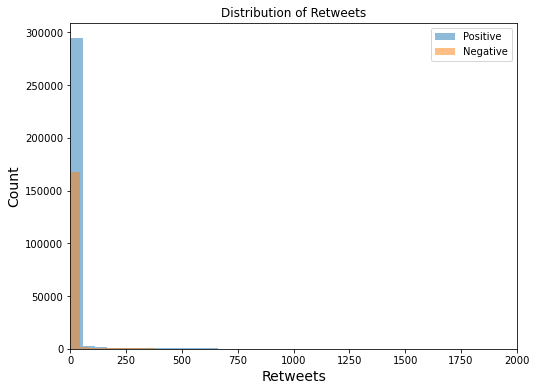

CPU times: user 25.6 s, sys: 467 ms, total: 26 s
Wall time: 27 s


In [68]:
%%time
# Destribution of retweets in linear scale, considering the tweets with no retweets as well
plt.figure(figsize=(8,6))
plt.hist(pos_sents.retweet_count, bins=10000, alpha=0.5, label="Positive")
plt.hist(neg_sents.retweet_count, bins=10000, alpha=0.5, label="Negative")

plt.xlabel("Retweets", size=14)
plt.ylabel("Count", size=14)
plt.xlim(0, 2000)
plt.title("Distribution of Retweets")
plt.legend(loc='upper right')

plt.show()

The data could be following a power law with a heavy-tailed distribution, in the following graph we plot the data in a log-log scale. To do so we are going to remove the data with retweets recont equals to 0.

In [69]:
# only tweets which have been retweeted

pos_retweeted = pos_sents.loc[pos_sents['retweet_count'] > 0]
neg_retweeted = neg_sents.loc[neg_sents['retweet_count'] > 0]

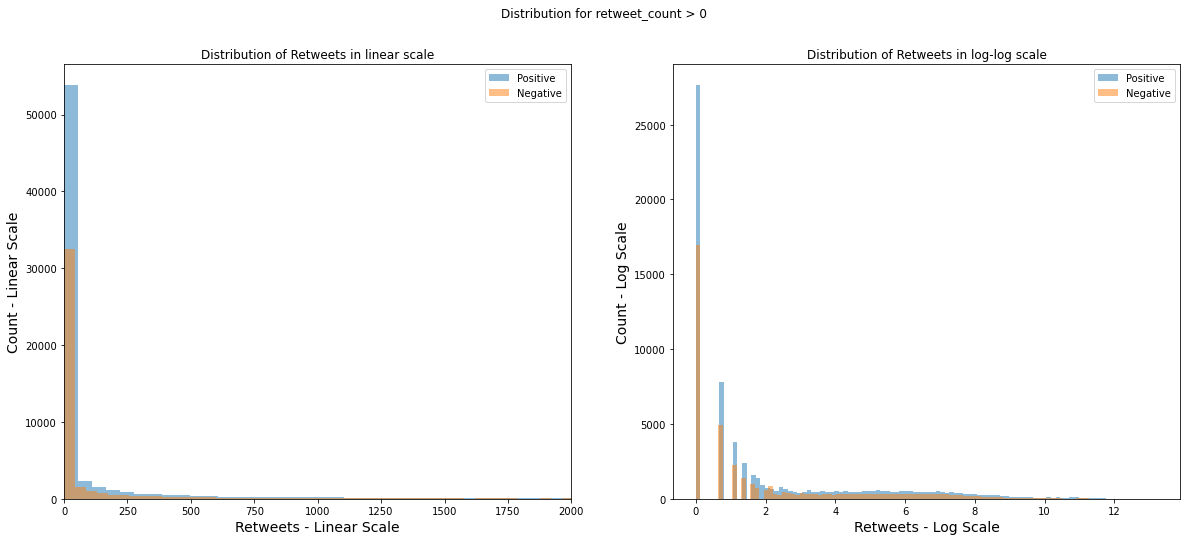

In [70]:
plt.figure(figsize=(20,8))
plt.suptitle('Distribution for retweet_count > 0')


# Distribution of tweets actually retweeted in linear scale
plt.subplot(1, 2, 1)
plt.hist(pos_retweeted.retweet_count, bins=10000, alpha=0.5, label="Positive")
plt.hist(neg_retweeted.retweet_count, bins=10000, alpha=0.5, label="Negative")

plt.xlabel("Retweets - Linear Scale", size=14)
plt.ylabel("Count - Linear Scale", size=14)
plt.xlim(0, 2000)
plt.title("Distribution of Retweets in linear scale")
plt.legend(loc='upper right')          
 
# Distribution of retweets in log log scale
plt.subplot(1, 2, 2)
plt.hist(pos_retweeted.retweet_count.apply(np.log), bins=100, alpha=0.5, label="Positive")
plt.hist(neg_retweeted.retweet_count.apply(np.log), bins=100, alpha=0.5, label="Negative")

plt.xlabel("Retweets - Log Scale", size=14)
plt.ylabel("Count - Log Scale", size=14)
plt.title("Distribution of Retweets in log-log scale")
plt.legend(loc='upper right')


plt.show()

The distribution of retweets seems even more skewed than a power law distribution. This means that we must not use statistics such as the mean value because they are highly unstable and misleading in this type of distribution.

In [71]:
pos_retweeted['retweet_count'].describe()

count     71026.000000
mean       1299.705756
std        9611.357475
min           1.000000
25%           1.000000
50%           3.000000
75%          48.000000
max      551788.000000
Name: retweet_count, dtype: float64

In [72]:
neg_retweeted['retweet_count'].describe()

count     43708.000000
mean        711.861215
std        5994.390759
min           1.000000
25%           1.000000
50%           3.000000
75%          49.000000
max      426173.000000
Name: retweet_count, dtype: float64

Also from this simple description of the data we can see that they are highly skewed.


When looking at simple statistics, we see that positive sentiment tweets have a much larger standard deviation, so there is more likely a significantly larger number of tweets with large retweet counts. 

In [73]:
#although mean isn't a good thing to compare with powerlaws, it is interesting to look at
# average of retweets in original df

print("The average number of retweets for positive tweets is {:.2f}".format(pos_sents.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_sents.retweet_count.mean()))

The average number of retweets for positive tweets is 296.05
The average number of retweets for negative tweets is 174.01


In [74]:
# average of retweets for tweets that have been retweeted at least once
print("The average number of retweets for positive tweets is {:.2f}".format(pos_retweeted.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_retweeted.retweet_count.mean()))

The average number of retweets for positive tweets is 1299.71
The average number of retweets for negative tweets is 711.86


In [75]:
#The ktest can also be used to see if two datasets come from the same distribution

great_k = stats.ks_2samp(pos_retweeted.retweet_count, neg_retweeted.retweet_count, alternative='greater')
less_k = stats.ks_2samp(pos_retweeted.retweet_count, neg_retweeted.retweet_count, alternative='less')

print('Alternative hypothesis that postive is greater: {} \n' \
    'Alternative hypothesis that postive is less: {}'.format(great_k,less_k))

Alternative hypothesis that postive is greater: KstestResult(statistic=0.006107819571167239, pvalue=0.13207293022869504) 
Alternative hypothesis that postive is less: KstestResult(statistic=0.014698516688873342, pvalue=8.253758886361194e-06)


We see that for the k test to see if the two sets come from the same distribution, we cannot reject the null that they come from the same distribution in favor of the alternative that the positive retweet distribution in greater.

However, when the alternative is that the positive distribution is less than the negative one, we can reject the null in favor of the alternative. So we find that the positive tweets tend to have a lower retweet count

In [76]:
pos_sents.sort_values(by=['retweet_count'], ascending = False)['retweet_count'].head(10)

296296    551788
635279    548016
911841    473644
391055    337006
960803    298331
121048    284859
324354    274359
802882    271210
976319    270488
912139    258869
Name: retweet_count, dtype: int64

In [77]:
neg_sents.sort_values(by=['retweet_count'], ascending = False)['retweet_count'].head(10)

516541    426173
635441    290667
635199    237713
282273    226724
635294    201765
281781    196806
324272    178398
326273    169294
424413    167615
619772    164964
Name: retweet_count, dtype: int64

Also, looking at the top 10 highest retweeted tweets for positive tweets we find that positive tweets have higher max retween count. So, even though positive retweets tend to have a higher max value, from the ktest we see they actually come from a lower distribution 

## Distribution of number of tweets per retweet count

In order to look at the distribution of number of tweets per retweet count we are going to take a subsample of positive tweets. Indeed, positive tweets are almost twice the number of negative tweets, therefore we cannot compare the histogram.

In [79]:
print('Now there are {} positive and {} negative tweets'.format(len(pos_retweeted), len(neg_retweeted)))

Now there are 71026 positive and 43708 negative tweets


In [80]:
pos_same_size = pos_retweeted.sample(len(neg_retweeted))

print("Now we look at {} postive tweets and {} negative tweets".format(len(pos_same_size),len(neg_retweeted)))

Now we look at 43708 postive tweets and 43708 negative tweets


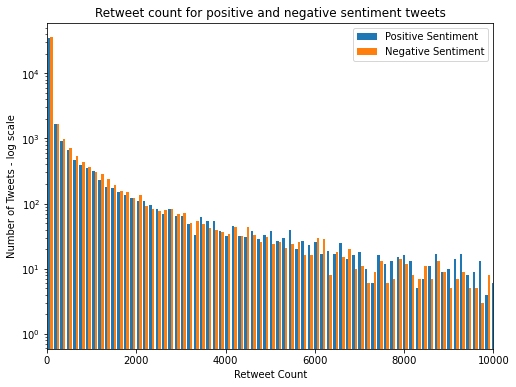

In [81]:
plt.figure(figsize=(8,6))

plt.hist([pos_same_size.retweet_count, neg_retweeted.retweet_count], bins=3000, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets - log scale')
plt.yscale('log')
plt.xlim([0, 10000])
plt.show()

From the above histogram we can see that negative tweets tend to perform better in terms of retweet count. At least at the lower level of retweet count. Indeed, for highr number of recounts the positive tweets seems to get more retweeted.

## Logistic Regression Analysis

Here we want to investigate whether it is possible to determine the retweetability of a tweet (meaning if it would be retweeted or not) based on several features such us follower and friends count, the presence of hashtags and the sentiment of the tweets.

In [82]:
subjective_tweets['positive'] = (subjective_tweets['sentiment'] == 'pos')
subjective_tweets['retweeted'] = (subjective_tweets['retweet_count'] > 0).astype(int)
subjective_tweets['has_hashtags'] = ~subjective_tweets['hashtags'].isna()

In [83]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(subjective_tweets[['positive']], subjective_tweets['retweeted'])
print(f'The logistic equation is r = {logistic.intercept_[0]:.2f} + p * {logistic.coef_[0][0]:.2f}')

The logistic equation is r = -1.13 + p * -0.03


In [84]:
d = {'positive': True}
ddf = pd.DataFrame(data=d, index=[0])
prob = logistic.predict_proba(ddf)
print(f'A positive tweet has a {prob[0][1] * 100:.2f}% chance of being retweeted.')

d = {'positive': False}
ddf = pd.DataFrame(data=d, index=[0])
prob = logistic.predict_proba(ddf)
print(f'A negative tweet has a {prob[0][1] * 100:.2f}% chance of being retweeted.')

A positive tweet has a 23.74% chance of being retweeted.
A negative tweet has a 24.36% chance of being retweeted.


In [85]:
mod_logistic_three = smf.logit(
    formula='retweeted ~ user_followers_count + user_friends_count + C(has_hashtags) + C(positive)',
    data = subjective_tweets
)

# Fit the model  adding a random seed to ensure consistency
np.random.seed(42)
res_tree = mod_logistic_three.fit()

# reporting the summary of the model
print(res_tree.summary())

Optimization terminated successfully.
         Current function value: 0.544565
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              retweeted   No. Observations:               694531
Model:                          Logit   Df Residuals:                   694526
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                 0.01029
Time:                        18:07:12   Log-Likelihood:            -3.7822e+05
converged:                       True   LL-Null:                   -3.8215e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.2771      0.005   -234.515      0.000      -1.288   

Looking at the coefficients for the logrithmic regression equation. We see having a positive tweet has a small, but negative impact on if the tweet is retweeted or not 

# Step 10. Twitter Users Analysis
___

In [86]:
# Let's see some user's names with the correspective numbers of clean tweets
en_tweets.groupby(["user_name"]).count()['clean_tweet']

user_name
  ♥ AaLiYaH ♥       82
 almer               2
 angieespino         2
 niallcumming        4
 العابرون            7
                  ... 
🕊                 2101
🗝                 1661
🦇 Trîstãn 🦇          1
🦊🐥🐰🐶🐱🐹              29
🧍‍♀️              2740
Name: clean_tweet, Length: 6167, dtype: int64

In [87]:
# creating a new df gouped by users. For each user we want the total number of tweets and retweets, in total and divided according to their sentiment,
# the total number of followers and of friends

sent_follow = en_tweets.groupby(["user_name"]).apply(lambda x:  pd.Series({
        'total_tweets': x['clean_tweet'].count(),
        'pos_tweets': len(x.loc[x['sentiment'] == 'pos']),
        'neu_tweets': len(x.loc[x['sentiment'] == 'neu']),
        'neg_tweets': len(x.loc[x['sentiment'] == 'neg']),
        'num_followers': x['user_followers_count'].max(),
        'num_friends': x['user_friends_count'].max(),
        'num_retweet': x['retweet_count'].sum(),
        'num_retweet_pos': x.loc[x['sentiment'] == 'pos'].retweet_count.sum(),
        'num_retweet_neu': x.loc[x['sentiment'] == 'neu'].retweet_count.sum(),
        'num_retweet_neg': x.loc[x['sentiment'] == 'neg'].retweet_count.sum()
    }))

In [88]:
sent_follow.head(10)

,total_tweets,pos_tweets,neu_tweets,neg_tweets,num_followers,num_friends,num_retweet,num_retweet_pos,num_retweet_neu,num_retweet_neg
user_name,,,,,,,,,,
♥ AaLiYaH ♥,82,21,45,16,4,70,0,0,0,0
almer,2,1,1,0,3,26,9,9,0,0
angieespino,2,2,0,0,0,2,0,0,0,0
niallcumming,4,4,0,0,1,95,30,30,0,0
العابرون,7,4,3,0,55,136,13,13,0,0
! طــايــش بـــس عـا,1,1,0,0,8,217,0,0,0,0
!KING!,304,63,186,55,48,234,25944,16710,6441,2793
#EndSARS,181,66,84,31,134,158,19082,700,17588,794
#GLAZERSOUT,331,100,188,43,43,358,152352,48353,100335,3664


For curiosity, let's check out the tweets from the user "!KING!". We can see that he published in total 304 tweets: 63 were considered positive, 55 negative and the remaining neutral. For these tweets in total he has 25944 retweets, and among these 16710 retweets were for positive tweets, 2793 for negative and 6441 for neutral.

In [89]:
en_tweets.loc[en_tweets['user_name'] == '!KING!'].head(5)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,weekday,weekday_name,sent_score,sentiment,sentiment_001,sent_score_no_sw,sentiment_no_sw,bert_sentiment,bert_score,vader_sentiment
410365,NaN,Tue Jul 31 19:23:27 +0000 2012,NaN,NaN,http://instagr.am/p/Nwb_y3TXpR/,0,230383188730580992,NaN,NaN,NaN,...,1.0,Tuesday,0.0000,neu,neu,0.0000,neu,pos,0.998126,neu
410366,NaN,Sun Jul 29 12:45:19 +0000 2012,NaN,NaN,http://instagr.am/p/NqkwGQTXjn/,0,229558220270743552,NaN,NaN,NaN,...,6.0,Sunday,0.4588,pos,pos,0.4588,pos,pos,0.999655,pos
410369,NaN,Wed Aug 15 05:11:56 +0000 2012,NaN,NaN,http://instagr.am/p/OVicsrTXiD/,0,235604716527169536,NaN,NaN,NaN,...,2.0,Wednesday,0.0000,neu,neu,0.0000,neu,pos,0.996531,neu
410370,NaN,Mon Sep 10 14:40:29 +0000 2012,NaN,NaN,http://instagr.am/p/PZgIJmzXlc/,0,245169879920037888,NaN,NaN,NaN,...,0.0,Monday,0.0000,neu,neu,0.0000,neu,neg,0.986783,neu
410371,NaN,Mon Aug 20 12:32:44 +0000 2012,NaN,NaN,http://instagr.am/p/OjMr3-zXrj/,0,237527589030342656,NaN,NaN,NaN,...,0.0,Monday,0.1511,neu,pos,0.1511,pos,neg,0.999359,pos


In [90]:
# Checking which tweets from this user got most retweeted

en_tweets.loc[en_tweets['user_name'] == '!KING!'].retweet_count.sort_values(ascending = False)


410586    11910
410608     1707
410587     1404
410652     1264
410647     1238
          ...  
410536        0
410535        0
410534        0
410533        0
410365        0
Name: retweet_count, Length: 304, dtype: int64

In [91]:
#Let's see the most retweeted tweet from !KING!

print(en_tweets.loc[en_tweets.index == 410586]['clean_tweet'])
print(en_tweets.loc[en_tweets.index == 410586]['vader_sentiment'])

410586     God Is Good
Name: clean_tweet, dtype: object
410586    pos
Name: vader_sentiment, dtype: object


Before proceeding with the analysis we will filter the users. We will mantain the ones who have at least 5 tweets, 1 negative and 1 positive, and with at least one retweeted tweet.

In [92]:
print("Before filtering we have {} users to compare".format(len(sent_follow)))

Before filtering we have 6167 users to compare


In [93]:
# Filtering tweet users
sent_follow_filtered = sent_follow.loc[(sent_follow['total_tweets'] > 5) &
                                       (sent_follow['pos_tweets'] > 1) &
                                       (sent_follow['neg_tweets'] >1)&
                                       (sent_follow['num_retweet'] >0)]

In [94]:
print("After filtering we have {} users to compare.".format(len(sent_follow_filtered)))

After filtering we have 1771 users to compare.


In [95]:
# Percentages of positive and negative tweet, adding this value to the sent_follow_filtered df
sent_follow_filtered['pos_perc'] = (sent_follow_filtered['pos_tweets']/sent_follow_filtered['total_tweets'])*100
sent_follow_filtered['neg_perc'] = (sent_follow_filtered['neg_tweets']/sent_follow_filtered['total_tweets'])*100

# Percentages of retweets for the positive and negative tweet, adding this value to the sent_follow_filtered df
sent_follow_filtered['num_retweet_pos_perc'] = (sent_follow_filtered['num_retweet_pos']/sent_follow_filtered['num_retweet'])*100
sent_follow_filtered['num_retweet_neg_perc'] = (sent_follow_filtered['num_retweet_neg']/sent_follow_filtered['num_retweet'])*100


We want to investigate if the number of followers somehow affect the number of retweets each tweets get on average.

In [96]:
# Creating a df grouping users by number of followers

df_followers = sent_follow_filtered.groupby('num_followers').agg({"neg_perc":"mean", "pos_perc":"mean",\
                                                                  "num_retweet_neg_perc":"mean", "num_retweet_pos_perc":"mean"})
df_followers

,neg_perc,pos_perc,num_retweet_neg_perc,num_retweet_pos_perc
num_followers,,,,
0,21.030495,29.545459,32.683498,21.574710
1,23.055083,28.678719,19.497400,33.577098
2,20.105505,34.924510,16.556938,29.199710
3,22.378132,32.047346,31.860952,25.381348
4,20.508459,34.260949,18.968168,27.946432
...,...,...,...,...
22899,3.946330,35.911602,0.882353,37.176471
23503,21.311475,22.201405,26.976296,19.827178
24819,8.241575,36.670003,8.984660,37.633309


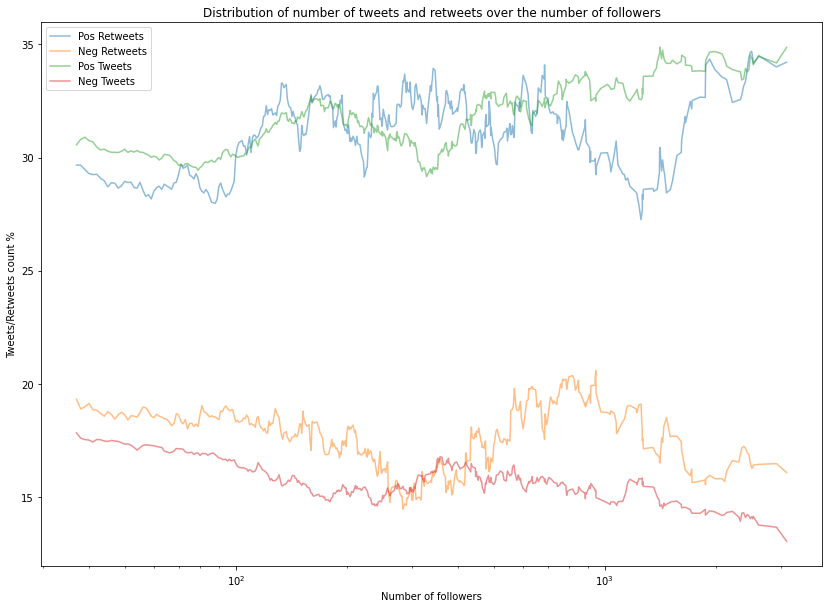

In [97]:
# applying moving average filter on tweets and retweets percentage 
average_follower = 75

num_retweet_neg_perc_averaged = df_followers.num_retweet_neg_perc.rolling(average_follower, center=True).mean().dropna()
num_retweet_pos_perc_averaged = df_followers.num_retweet_pos_perc.rolling(average_follower, center=True).mean().dropna()

num_tweet_neg_perc_averaged = df_followers.neg_perc.rolling(average_follower, center=True).mean().dropna()
num_tweet_pos_perc_averaged = df_followers.pos_perc.rolling(average_follower, center=True).mean().dropna()


# plotting

plt.figure(figsize=(14,10))
plt.plot(num_retweet_pos_perc_averaged.index, num_retweet_pos_perc_averaged, alpha=0.5, label="Pos Retweets")
plt.plot(num_retweet_neg_perc_averaged.index,num_retweet_neg_perc_averaged , alpha=0.5, label="Neg Retweets")

plt.plot(num_tweet_pos_perc_averaged.index, num_tweet_pos_perc_averaged, alpha=0.5, label="Pos Tweets")
plt.plot(num_tweet_neg_perc_averaged.index,num_tweet_neg_perc_averaged , alpha=0.5, label="Neg Tweets")

plt.legend(loc = 'upper left')
plt.title('Distribution of number of tweets and retweets over the number of followers')
plt.xlabel('Number of followers')
plt.ylabel('Tweets/Retweets count %')
#plt.yscale('log')
plt.xscale('log')

plt.show()




From the previous plot we can see that the number of followers does not really change the positivity of posted tweets. Around 15-18% of the posted tweets are negative, and around 30% of the posted tweets per user are positive. If we look at the percentage of retweets coming from positive tweets, it is around 30% as well; whereas the percentage coming from negative tweets is a slightly higher than the percentage of negative retweets.

## Step 11. Topic Analysis 
___

**Empath lexicon**

We are going to use [*Empath*](https://github.com/Ejhfast/empath-client), a tool for analyzing text across lexical categories. It will be used to extract tweets that can be related to a certain topic.

In [98]:
lexicon = Empath()

We show an example of usage for two different sentences

In [99]:
example_1 = "We love playing basketball"
example_2 = "We love playing the guitar"
for ex in [example_1, example_2]:
    print(f"Sentence:\t{ex}")
    print(f"Result:\t\t{lexicon.analyze(ex, categories = ['sports', 'music'])}")
    print(f"Normalized result:\t{lexicon.analyze(ex, categories = ['sports', 'music'], normalize = True)}\n")
    
print("Explanation: 'playing' and 'basketball' are in the sports keyword set,"
      " whereas 'guitar' falls into the music keywords set.")

Sentence:	We love playing basketball
Result:		{'sports': 2.0, 'music': 0.0}
Normalized result:	{'sports': 0.5, 'music': 0.0}

Sentence:	We love playing the guitar
Result:		{'sports': 1.0, 'music': 1.0}
Normalized result:	{'sports': 0.2, 'music': 0.2}

Explanation: 'playing' and 'basketball' are in the sports keyword set, whereas 'guitar' falls into the music keywords set.


**Lexical Categories**

In [100]:
categories = list(lexicon.cats.keys())
categories.sort()
print(f"There are {len(categories)} predefined categories.\nSome of the categories are: {categories[:20] + ['...']}")
print(f"\nEach category contains a set of keywords:\nsports: {lexicon.cats['sports'][:20] + ['...']}")

There are 194 predefined categories.
Some of the categories are: ['achievement', 'affection', 'aggression', 'air_travel', 'alcohol', 'ancient', 'anger', 'animal', 'anonymity', 'anticipation', 'appearance', 'art', 'attractive', 'banking', 'beach', 'beauty', 'blue_collar_job', 'body', 'breaking', 'business', '...']

Each category contains a set of keywords:
sports: ['goalkeeper', 'lifeguard', 'champion', 'quarterback', 'hiking', 'play', 'wrestler', 'rowing', 'touchdown', 'warmup', 'skills', 'medal', 'playing', 'spectator', 'biking', 'sporty', 'compete', 'coaching', 'mascot', 'track', '...']


We will select 8 of these categories:<br>*sports, politics, music, religion, health, cooking, fashion, and family*

In [101]:
CATEGORIES = ["sports", "politics", "music", "religion", "health", "cooking", "fashion", "family"]

**Computing topic extraction**

Let's compute the category scores for each tweet, and then select the most probable category if any detected. Or load the already computed dataset (saving time).

In [102]:
%%time
categorized_dataset = 'Data/categorized_tweets.csv'
load_df = False

if not os.path.isfile(categorized_dataset) or not load_df:
    
    def score_categories(x, cats=CATEGORIES):
        cat_scores = lexicon.analyze(x.text, categories = cats)
        return [int(x) for x in list(cat_scores.values())]

    df_cats = en_tweets.apply(score_categories, axis=1)
    df_cats = pd.DataFrame(df_cats.to_list(), index=df_cats.index, columns=CATEGORIES)
    en_tweets = en_tweets.join(df_cats)

    # Extracting the category with the maximum number of occurrences
    def max_category(x, cats=CATEGORIES):
        array = [x[cat] for cat in cats]
        if np.sum(array) == 0:
            res = np.nan
        elif array.count(max(array)) > 1:
            res = np.nan
        else:
            res = cats[np.argmax(array)]
        return res

    en_tweets['category'] = en_tweets[CATEGORIES].apply(max_category, axis=1)
    
    # Write dataset
    en_tweets.to_csv(categorized_dataset, index=False)
    
# Read already created dataset
elif os.path.isfile(categorized_dataset) and 'category' not in en_tweets.columns and load_df:
    en_tweets = pd.read_csv(categorized_dataset)

CPU times: user 7min, sys: 15 s, total: 7min 15s
Wall time: 7min 28s


For each category, we have counted the number of keywords present in the text. Then, the category with more keywords is considered the actual category of the tweet.

In [103]:
print(f"{en_tweets['category'].isna().value_counts()[False]} tweets were categorized;"
      f" {en_tweets['category'].isna().value_counts()[False]/len(en_tweets)*100:.2f}% of the total {len(en_tweets)} tweets.")

124512 tweets were categorized; 11.81% of the total 1054619 tweets.


Categorized tweets keyword count:

In [104]:
en_tweets[en_tweets.columns[-(len(CATEGORIES)+1):]][~en_tweets['category'].isna()].sample(n=4, random_state=0)

,sports,politics,music,religion,health,cooking,fashion,family,category
502254,0,0,1,0,0,0,0,0,music
954862,0,0,0,0,0,1,0,0,cooking
945761,0,0,0,0,0,0,0,1,family
941737,0,0,0,0,0,1,0,0,cooking


Let's show the amount of tweets we extrated per category

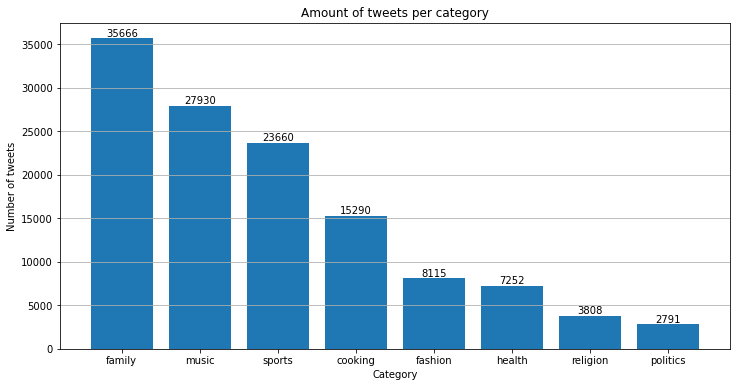

In [105]:
counts_series = en_tweets['category'].value_counts()

plt.figure(figsize=(12,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.grid(axis='y')
plt.title('Amount of tweets per category')
plt.ylabel('Number of tweets')
plt.xlabel('Category')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

## Group statistics

We are going to create a column to show whether a tweet was retweeted or not

In [106]:
en_tweets['retweetability'] = en_tweets['retweet_count'] > 0

And compute some statistics per category

In [107]:
group_stats =   (en_tweets[['category', 'text', 'retweet_count', 'favorite_count', 'retweetability']]
                 .groupby('category')
                 .agg({'text':'count', 'retweet_count':['mean', 'std'], 'retweetability':'mean', 'favorite_count':['mean', 'std']})
                 .sort_values(('retweet_count', 'mean'), ascending=False)
                )

In [108]:
def highlight_max(data): #, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold'
    #attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [109]:
group_stats.style.apply(highlight_max, axis=0)# % 'bold')

`music` has the highest mean retweets, but`politics` is more retweetable (retweeted or not). If we look at the amount of favorites given to a tweet, `religion` has the maximum mean of favorites

What happens if we add the sentiment information??

In [110]:
grouped_cat_sent = (en_tweets[en_tweets['sentiment'] != 'neu']
                    [['category', 'sentiment', 'text', 'retweet_count', 'favorite_count', 'retweetability']]
                 .groupby(["category", "sentiment"])
                 .agg({'text':'count', 'retweet_count':['mean', 'std'], 'retweetability':'mean', 'favorite_count':['mean', 'std']})
                 #.sort_values(('retweet_count', 'mean'), ascending=False)
                )

In [111]:
grouped_cat_sent.style.apply(highlight_max, axis=0)# % 'bold')

The sentiment adds more information and shows that there are some categories more retweetable depending on their sentiment. Tweets about `family`, `health`, `music` and `sports`get higher mean retweets for positive sentiment, whereas `politics` and `cooking`are more retweetable and it gets more favorite counts with negative sentiment.

### Showing some of the tweets

In [112]:
def sample_tweets(cat, N=10, seed=None, min_rt=0):
    df_w = (en_tweets[(en_tweets['category']==cat) & (en_tweets['retweet_count'] > min_rt)]
            [['retweet_count', 'favorite_count', 'text', 'user_name']]
           )
    for rt, fav, tweet, user in df_w.sample(n=min(N, len(df_w)), random_state=None).values:
        print(f"RTs: {str(rt).ljust(4)}\tFavs: {str(fav).ljust(4)}\tUser: {user.ljust(15)} Tweet: {tweet}")

In [113]:
sample_tweets('religion', min_rt=10)

RTs: 1174	Favs: 0   	User: Nuke Waste 🚮    Tweet: RT @TeamNikeNick: The church at the end of my street has no chill 😂 http://t.co/MMJIcsfENh
RTs: 516 	Favs: 0   	User: Bailey Dewitt   Tweet: RT @DateLocations: preach 🍺 + 🏊 http://t.co/9ubcTujXlr
RTs: 193 	Favs: 0   	User: Josh Duckhouse  Tweet: RT @TroyBakerVA: The irony of the situation is that by citing "religious freedom" #HobbyLobby itself imposes religious persecution on it's …
RTs: 11  	Favs: 0   	User: leilah wright   Tweet: RT @unspokenmusic: We are called to not just pray to Jesus but to Follow Him.
RTs: 19  	Favs: 0   	User: Courtney Smith  Tweet: RT @mikebickle: It’s our spiritual inheritance to walk in the freedom described by the 8 Beatitudes.
RTs: 94591	Favs: 0   	User: Samantha        Tweet: RT @Real_Liam_Payne: Looking forward to the show tonight in St. Louis which is defiantly not naked after my pal cuz he ain't no saint 😏
RTs: 93  	Favs: 0   	User: phillpafford    Tweet: RT @coinbase: .@Dell celebrates @coinbase partn

## Statistical Evaluation with plots

In [114]:
def bootstrap_stat_ci(array, statistic, repetitions=10000, alpha=0.05, resampling_size=None):
    if resampling_size is None:
        resampling_size = int(len(array))
    
    # For reproducibility
    np.random.seed(seed=0)
    
    bootstrap_distribution = []
    for i in range(repetitions):
        # resampled data
        bootstrap_sample = np.random.choice(array, size=resampling_size, replace=True)
        # computing the mean
        stat_sample = statistic(bootstrap_sample)
        # saving the statistic into the bootstrap distribution
        bootstrap_distribution.append(stat_sample)

    # Computing the bootstrap confidence interval
    mean = np.mean(bootstrap_distribution)
    left = np.percentile(bootstrap_distribution, alpha/2*100)
    right = np.percentile(bootstrap_distribution, (1-alpha/2)*100)
    
    return bootstrap_distribution, mean, (left, right)

def compute_statistic(df, statistic, categories, sentiment, feature):
    # Choosing statistic
    if statistic == 'median':
        stat_func = lambda x: np.median(x)
    elif statistic == 'mean_log':
        stat_func = lambda x: np.mean(np.log10(x))
    elif statistic == 'exp_mean_log':
        stat_func = lambda x: 10**np.mean(np.log10(x))
    elif statistic == 'mean':
        stat_func = lambda x: np.mean(x)
    
    # Computing bootstrap ci per category
    x, l_err, r_err = [], [], []
    
    for cat in categories:
        if sentiment:
            for sent in ['pos', 'neg']:
                values = df[df['category']==cat][df['sentiment']==sent][df[feature]>0][feature].values
                _, mean, (l_ci, r_ci) = bootstrap_stat_ci(values, statistic=stat_func)
                x.append(mean)
                l_err.append(mean-l_ci)
                r_err.append(r_ci-mean)
        else:
            values = df[df['category']==cat][df[feature]>0][feature].values
            _, mean, (l_ci, r_ci) = bootstrap_stat_ci(values, statistic=stat_func)
            x.append(mean)
            l_err.append(mean-l_ci)
            r_err.append(r_ci-mean)
    err = [l_err, r_err]
    return x, err

def plot_error_bar(x, err, categories, sentiment, statistic_name=''):
    y = np.linspace(1, 2*len(x)-1, len(x))
    height = 6 if sentiment else 3
    plt.figure(figsize=(10,height))
    plt.errorbar(x, y, xerr=err, fmt = 'o', color = 'tab:blue')
    if sentiment:
        categories = [' '.join([x,y]) for x in categories for y in ['pos', 'neg']]
        plt.yticks(tuple([0] + list(y) + [y[-1]+1]), tuple([''] + categories + ['']))
    else:
        plt.yticks(tuple([0] + list(y) + [y[-1]+1]), tuple([''] + categories + ['']))
    plt.title(statistic_name + ' per Category')
    plt.ylabel('Categories')
    plt.xlabel(statistic_name)
    plt.show()
    
def show(statistic, feature, categories=CATEGORIES, df=en_tweets, sentiment=False):
    x, err = compute_statistic(df, statistic, categories, sentiment, feature)
    plot_error_bar(x, err, categories, sentiment, statistic_name=' '.join([x.replace('_', ' ').title() for x in [statistic, feature]]))

We have to take into account that our distributions for retweets and favorites are similar to the Pareto/power law distribution. Therefore, we will show different statistics to describe the distribution per topic and per topic and sentiment. All the following statistics will be shown with bootstrap confidence intervals:
- mean
- median
- Expectation of log value: $10^{\sum_{i=1}^{N}\dfrac{log_{10}(x)}{N}}$

The expectation of the log value is regarded as an interesting statistic for the Pareto distribution becuase it is a sufficient statistic. [Stack exchange question](https://stats.stackexchange.com/questions/121925/intuitive-descriptive-statistics-for-power-law-distributions)

**Retweet statistics per category**

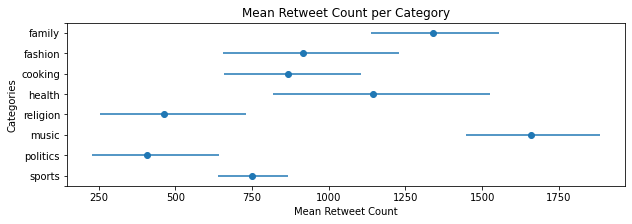

In [115]:
show('mean', 'retweet_count')

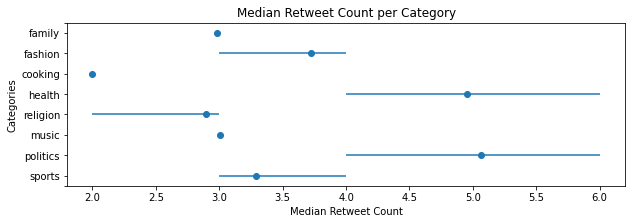

In [116]:
show('median', 'retweet_count')

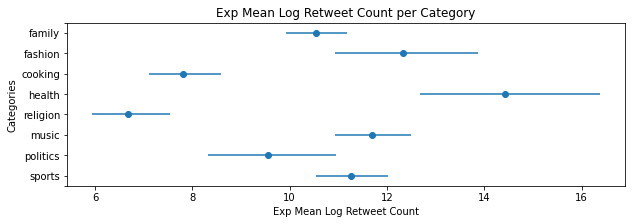

In [117]:
show('exp_mean_log', 'retweet_count')

**Retweet statistics per category and sentiment**

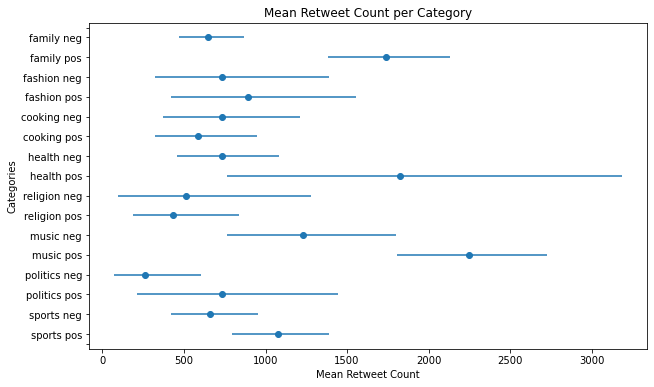

In [118]:
show('mean', 'retweet_count', sentiment=True)

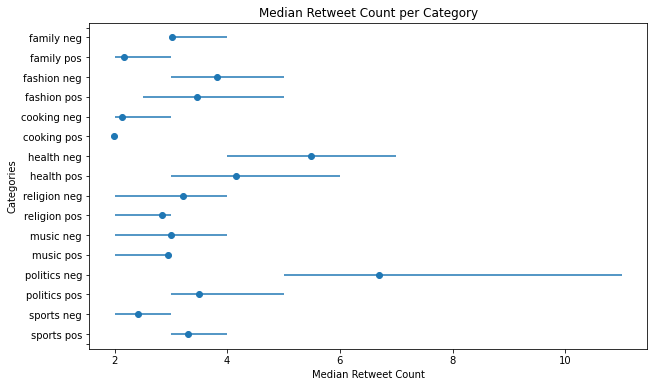

In [119]:
show('median', 'retweet_count', sentiment=True)

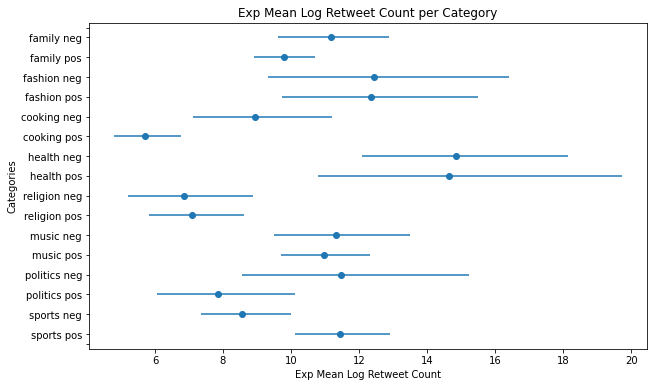

In [120]:
show('exp_mean_log', 'retweet_count', sentiment=True)

**Favorite statistics per category**

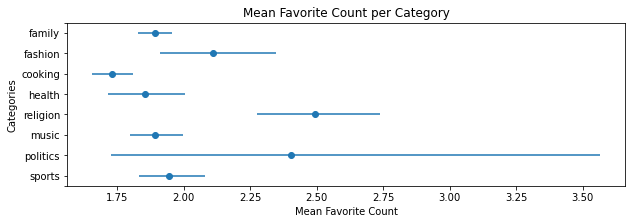

In [121]:
show('mean', 'favorite_count')

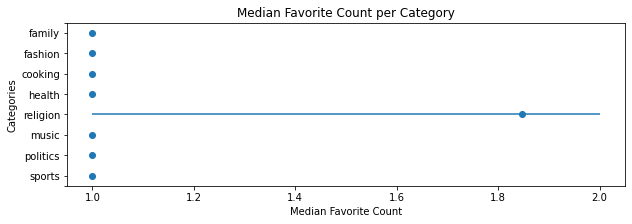

In [122]:
show('median', 'favorite_count')

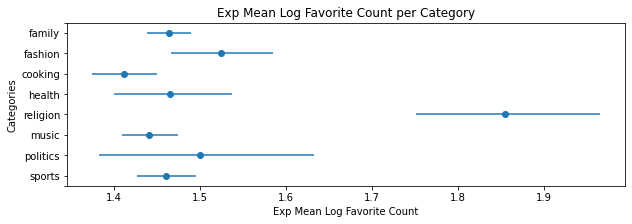

In [123]:
show('exp_mean_log', 'favorite_count')

**Favorite statistics per category and sentiment**

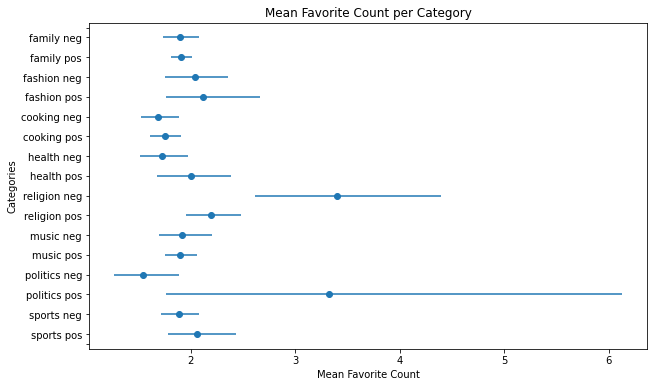

In [124]:
show('mean', 'favorite_count', sentiment=True)

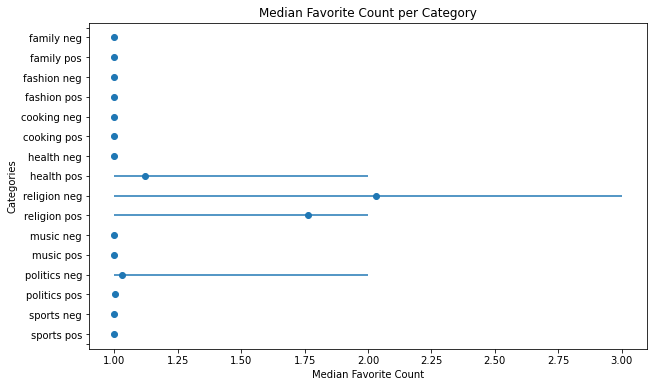

In [125]:
show('median', 'favorite_count', sentiment=True)

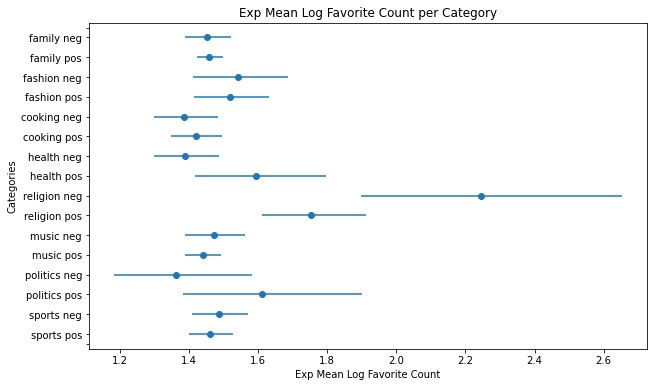

In [126]:
show('exp_mean_log', 'favorite_count', sentiment=True)